# Sentiment-Based Product Recommendation System

## Business Context (Problem Statment)

E-commerce companies such as **Amazon**, **Flipkart**, and **Myntra** are highly competitive in today's market.  
The company **Ebuss** is aiming to scale rapidly across various product categories — household essentials, books, beauty products, personal care, electronics, and more.

As a **senior ML Engineer**, you are asked to **build a Sentiment-based Product Recommendation System** that will improve the recommendations given to the users given their past reviews and ratings.

---

## Project Objective

To recommend the best products to users based on:

Their past reviews and ratings  
The sentiment of other users’ reviews on products  
Collaborative filtering techniques (User-Based & Item-Based)  

Ultimately, to deploy this as an **end-to-end system with a web UI**.

---

## Project Steps

### 1. Exploratory Data Analysis (EDA)

- Understand data distribution
- Check class imbalance
- Identify missing/null values

### 2. Data Cleaning & Preprocessing

- Cleaning text reviews
- Removing special characters, stop words
- Lemmatization
- Feature Engineering

### 3. Feature Extraction

### 4. Sentiment Classification Model

Build & compare at least 3 ML models (out of 4):

- Logistic Regression
- Random Forest
- XGBoost
- Naive Bayes

Key focus:

- Handle class imbalance (SMOTE)
- Hyperparameter tuning (GridSearchCV)
- Metrics evaluated: Accuracy, Precision, Recall, F1, Specificity

### 5. Recommendation System

Develop **2 types** of recommendation systems:

- User-Based Collaborative Filtering (UBCF)
- Item-Based Collaborative Filtering (IBCF)

Finally linked with **sentiment model**:

- Recommend Top 20 products → Filter Top 5 based on sentiment score

---

## Deployment: Full End-to-End System

- Web app build using **Flask**
- Deploy using **Heroku (PaaS)**

### UI Features:

Input Username (existing)  
Submit button → Fetch Top 5 recommended products  

---

## Important Notes

- Number of users and products is **fixed** in this case study.  

---

This notebook contains:

Complete EDA → Model training → Recommendation engine
All models and hyperparameter tuning steps

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## for google colab
data_directory = "/content/drive/MyDrive/Colab Notebooks/Capstone/Sentiment Product Recommendation/data/"
pickle_directory = "/content/drive/MyDrive/Colab Notebooks/Capstone/Sentiment Product Recommendation/pickle/"
## for local
## data_directory = "data/"
## pickle_directory = "pickle/"

In [3]:
import os
import json
import re
import warnings
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from numpy import *

import pickle as pickle

# Ignore warnings
warnings.filterwarnings("ignore")

# 1. Exploratory Data Analysis

In [ ]:
original_data = pd.read_csv(data_directory + "sample30.csv")

In [ ]:
original_data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [ ]:
original_data.shape

(30000, 15)

In [ ]:
# Understand the given data.
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

* Several columns contain NULL values, which will need to be addressed in later stages.
* Some columns may not be relevant for building the Sentiment and Recommender models; we will evaluate and eliminate these as needed.

##### Create a working copy of the dataset

In [ ]:
reviews_df = original_data.copy()

#### Distribution of Ratings

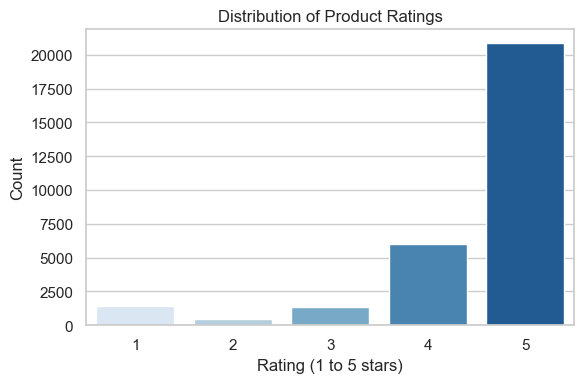

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x="reviews_rating", data=reviews_df, palette="Blues")
plt.title("Distribution of Product Ratings")
plt.xlabel("Rating (1 to 5 stars)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Distribution of Product Ratings

In this plot, we analyze how the product ratings are distributed in our dataset.

#### Observations:
- The **x-axis** represents product ratings (from 1 star to 5 stars).
- The **y-axis** represents the count of reviews for each rating.

#### Insights:
- The distribution is highly **right-skewed**.
- A **large majority** of reviews are **5-star ratings** — more than 20,000 reviews.
- 4-star reviews are the second most common (~6000 reviews).
- Ratings of 1, 2, or 3 stars are comparatively **much fewer** in number.

#### Implications:
- The dataset is **imbalanced** with respect to the target (`reviews_rating`).
- Such imbalance may affect the performance of classification models — models may tend to overpredict 5-star reviews.
- Techniques like **class balancing** (SMOTE / class_weight / resampling) might be required during model building.

#### Next steps:
- We will explore this further during recommendation phases.

#### Distribution of user_sentiment

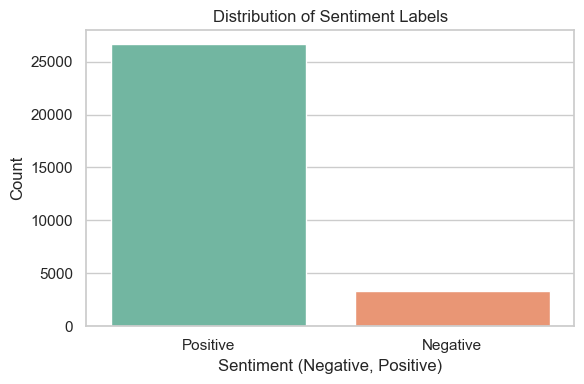

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="user_sentiment", data=reviews_df, palette="Set2")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment (Negative, Positive)")
plt.ylabel("Count")
plt.xticks(['Negative', 'Positive'])
plt.tight_layout()
plt.show()

### Distribution of `user_sentiment`

In this plot, we visualize the distribution of user_sentiment in our dataset.

#### Plot description:
- **x-axis**: user_sentiment (Negative, Positive)
- **y-axis**: Count of reviews for each sentiment

#### Observations:
- The dataset is **highly imbalanced**:
    - Majority of reviews are labeled as **Negative** — approximately 27,000 reviews.
    - A small fraction are **Positive** — less than 5,000 reviews.
- This imbalance could strongly bias the performance of any classification model toward predicting the majority class (Negative).

#### Implications:
- **Handling class imbalance** will be critical:
    - Techniques such as **SMOTE**, **Random Oversampling**, **class_weight='balanced'**, or **threshold tuning** will be needed.

#### Next Steps:
- Apply imbalance correction methods during text classification model building.
- Evaluate models not just by accuracy — but using **Precision, Recall, F1 Score** to properly reflect performance on both Positive and Negative classes.

#### Review Length Distribution

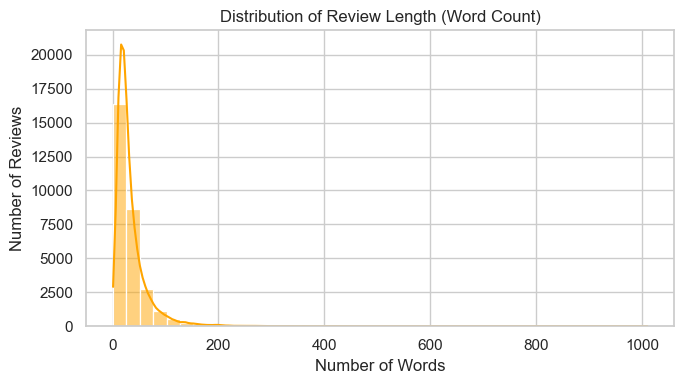

In [ ]:
reviews_df["review_length"] = reviews_df["reviews_text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7, 4))
sns.histplot(reviews_df["review_length"], bins=40, color="orange", kde=True)
plt.title("Distribution of Review Length (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

### Distribution of Review Length (Word Count)

In this plot, we visualize how long the product reviews are — based on **word count** per review.

#### Plot details:
- **x-axis**: Number of words per review (review length)
- **y-axis**: Number of reviews with that length

#### Observations:
- The majority of reviews are **short**:
    - Most reviews contain between **10 to 50 words**.
    - There is a sharp drop after ~100 words.
    - A long tail exists, but reviews with > 200 words are very rare.
- The distribution is **highly skewed right** (positive skew):
    - A few reviews go beyond 500–1000 words, but those are outliers.

#### Implications for modeling:
- Since the reviews are mostly short, **simple models like TF-IDF with unigrams/bigrams** can capture a lot of information.
- We should consider:
    - Limiting **max_features** in TF-IDF
    - Possibly clipping or truncating very long reviews (outliers)

#### Top 10 Most Reviewed Products

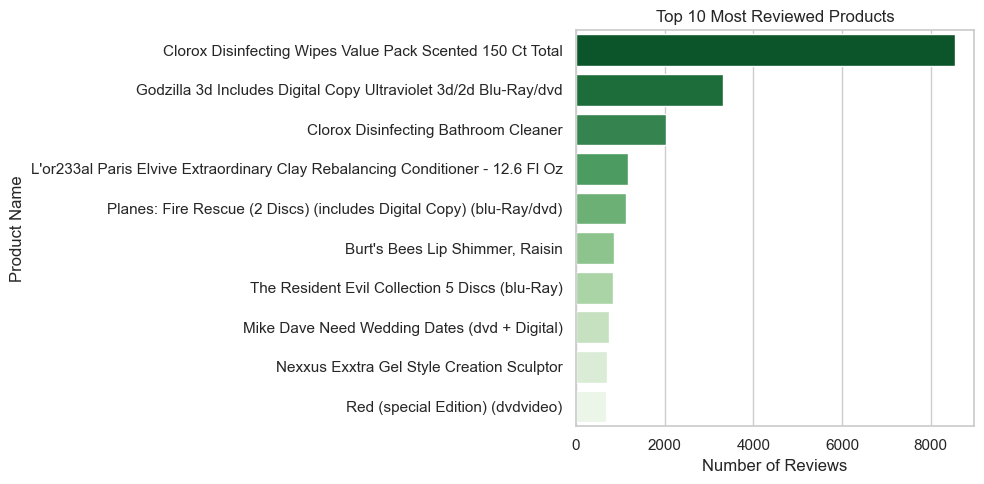

In [ ]:
top_products = reviews_df["name"].value_counts().head(10).reset_index()
top_products.columns = ["Product Name", "Review Count"]

plt.figure(figsize=(10, 5))
sns.barplot(y="Product Name", x="Review Count", data=top_products, palette="Greens_r")
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()


### Top 10 Most Reviewed Products

In this visualization, we see the **Top 10 products** by number of reviews.

#### Plot Details:
- **x-axis**: Number of reviews submitted
- **y-axis**: Product names
- The products are sorted by number of reviews in descending order.

#### Observations:
- There is **high variance** among products in terms of review count:
    - The most reviewed product — **Clorox Disinfecting Wipes Value Pack** — has over **8000 reviews**!
    - The second most reviewed — **Godzilla 3D Digital Copy Blu-Ray** — has much fewer (~4000 reviews).
    - Many other products have **2000–1000 reviews**.
- This shows that **a small number of products dominate user attention**:
    - Reviews are heavily skewed toward popular products.
    - The **review frequency is imbalanced across products**.
- The product mix is also varied — includes **household essentials, beauty products, movies/media**.

#### Implications for Recommendation:
- Recommendation models must:
    - Avoid bias toward popular products only.
    - Ensure sufficient product diversity.
    - Handle **cold-start problems** for products with fewer reviews.
- Hybrid models that combine **review sentiment** can help boost niche product recommendations.


#### Top 10 Most Active Users

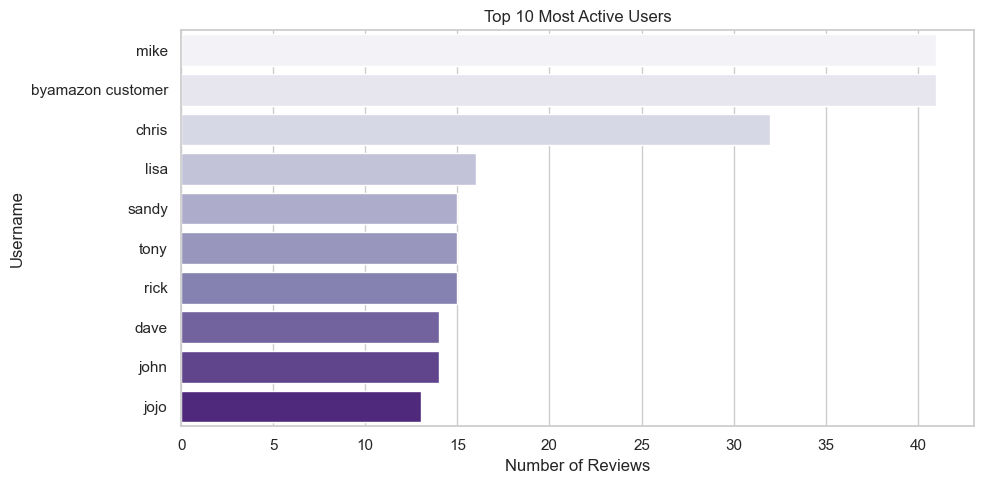

In [ ]:
top_users = reviews_df["reviews_username"].value_counts().head(10).reset_index()
top_users.columns = ["User", "Review Count"]

plt.figure(figsize=(10, 5))
sns.barplot(y="User", x="Review Count", data=top_users, palette="Purples")
plt.title("Top 10 Most Active Users")
plt.xlabel("Number of Reviews")
plt.ylabel("Username")
plt.tight_layout()
plt.show()

### Top 10 Most Active Users

This plot visualizes the **top 10 users** who have submitted the most reviews on the platform.

#### Plot Details:
- **x-axis**: Number of reviews posted
- **y-axis**: Usernames (either real names or aliases)
- Sorted in descending order.

#### Observations:
- The two most active users — **"mike"** and **"byamazon customer"** — have submitted **~40 reviews** each.
- The remaining users have posted between **10 to 30 reviews**.
- Some usernames are anonymous or generic (like "byamazon customer"), which may indicate either privacy choice or unregistered users.

#### Implications for Recommendation:
- Highly active users contribute **valuable information** for the recommendation engine:
    - Their reviews can help in understanding **product quality trends**.
    - They provide a **dense user-item matrix**, improving collaborative filtering models.
- Less active users will have **sparser data** (cold start), and will benefit from **hybrid approaches** using sentiment models.
- It is also important to detect if **bots** or **duplicate users** are inflating review counts — not seen here, but worth monitoring.

#### Conclusion:
- The activity level of users varies — the system needs to balance recommendations for both **high activity** and **low activity** users.

### Rating vs Sentiment Correlation

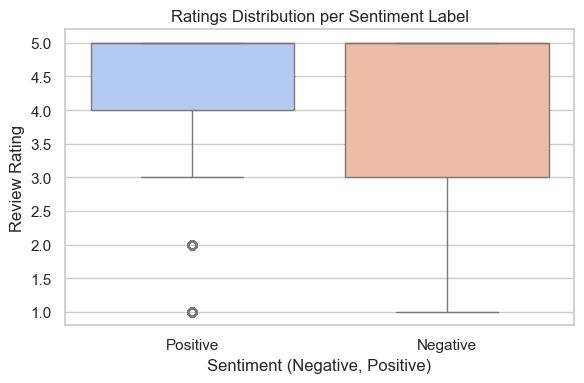

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="user_sentiment", y="reviews_rating", data=reviews_df, palette="coolwarm")
plt.title("Ratings Distribution per Sentiment Label")
plt.xlabel("Sentiment (Negative, Positive)")
plt.ylabel("Review Rating")
plt.xticks(['Negative', 'Positive'])
plt.tight_layout()
plt.show()

### Rating vs Sentiment Correlation

This boxplot visualizes the relationship between **user sentiment** and the corresponding **product ratings**.

#### Plot Details:
- **x-axis**: Sentiment label → `Negative` and `Positive`
- **y-axis**: Product ratings (scale 1 to 5 stars)
- **Boxplot** shows the distribution of ratings for each sentiment.

#### Observations:
- For **Positive Sentiment**:
    - Median rating ≈ 5 stars
    - Most ratings are between **4 to 5 stars**.
    - A few outliers below 3 stars (rare).

- For **Negative Sentiment**:
    - Median rating ≈ 3 stars.
    - Ratings spread wider — from **1 to 5 stars**.
    - Negative sentiment is more distributed (less predictable from rating alone).

#### Interpretation:
- There is a **clear positive correlation** between high ratings and positive sentiment.
- However:
    - Not all **low ratings** are mapped to "Negative" sentiment.
    - Some "Negative" sentiments occur with ratings **above 3 stars** — possibly due to:
        - Reviews mentioning positive + negative aspects.
        - Misalignment between text tone and numeric rating.
    - Some "Positive" sentiments have ratings below 4 (outliers).

#### Implications for Model:
- Using **rating alone** to predict sentiment will not be perfect.
- Therefore:
    - It is essential to build a **text-based sentiment classifier** (which we are already doing ).
    - The classifier can help correct misalignments (such as "5-star review with a negative text").
    - Combining **rating + text** can improve recommendation accuracy.

#### Final Note:
- This plot highlights the importance of using **sentiment analysis** — product ratings alone do not fully represent user sentiment.

#### Generate WordCloud for Most Common Words in Reviews

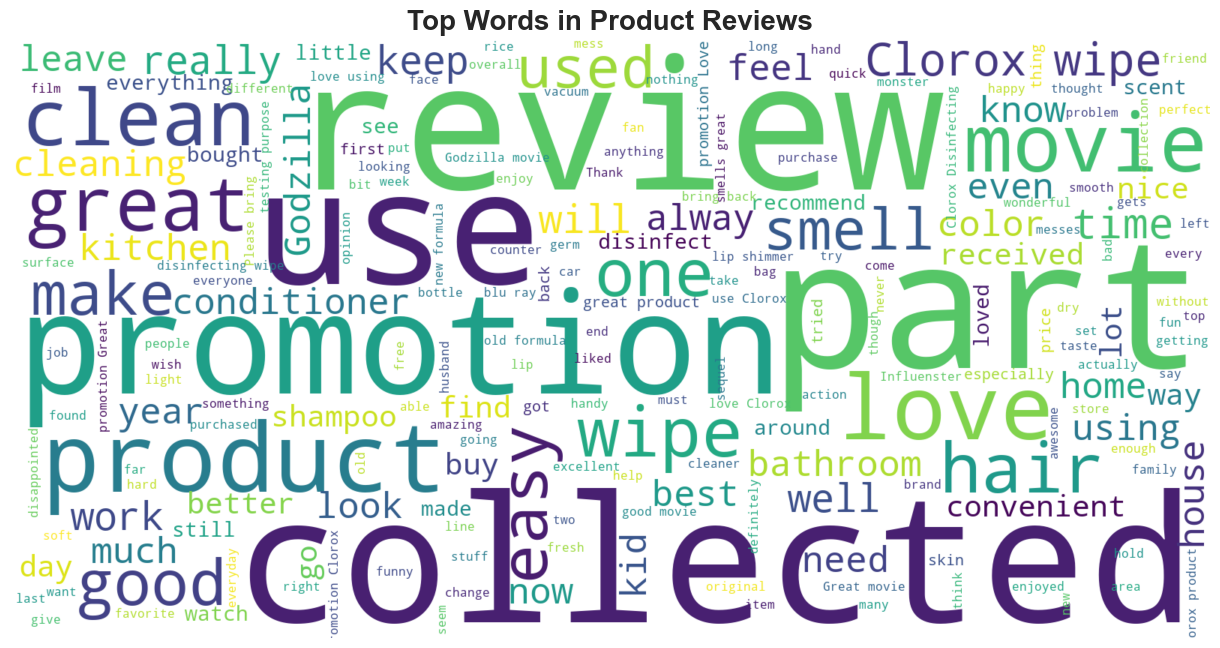

In [ ]:
# Prepare stopwords
stopwords = set(STOPWORDS)

# Combine all reviews into one string
all_reviews = " ".join(reviews_df['reviews_text'].astype(str).tolist())

# Generate WordCloud
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=60,
    scale=4,
    random_state=42,
    colormap='viridis'  # nice color palette
).generate(all_reviews)

# Plot the WordCloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words in Product Reviews", fontsize=20, fontweight='bold')
plt.tight_layout(pad=0)
plt.show()

### WordCloud Analysis — Top Words in Product Reviews

The WordCloud above visualizes the most frequent words used by customers in their product reviews.

#### Observations:
The largest and most prominent words are:  
**'collected'**, **'promotion'**, **'use'**, **'review'**, **'product'**, **'clean'**, **'great'**, **'part'**, **'movie'**, **'received'**.

Some clear patterns can be seen:
- Many users mention **promotional offers** (e.g., "promotion", "collected", "received", "reward", "coupon").
- **Product usability** is commonly highlighted (e.g., "use", "easy", "work", "love", "great").
- **Product categories** like **cleaning products** and **movies** also appear (e.g., "clean", "bathroom", "Clorox", "movie", "Godzilla").
- Words like **'good', 'better', 'nice', 'perfect'** indicate **positive sentiments** in many reviews.

#### Insights:
The reviews reflect that many customers:
1. Appreciate **promotional rewards**.
2. Value **ease of use** and **cleaning effectiveness**.
3. Comment on **product quality** in simple positive words.

The WordCloud confirms a strong alignment between **positive product feedback** and product marketing efforts (promotions).

---

# 2. Data Cleaning

In [ ]:
# Summary of Dataset — Reviews, Users, and Ratings

# Total number of reviews
total_reviews = len(reviews_df['reviews_text'])
print("Total number of reviews:", total_reviews)

# Number of unique reviewers (users)
unique_reviewers = len(reviews_df['reviews_username'].unique())
print("Number of unique reviewers:", unique_reviewers)

# Proportion of unique reviewers vs total reviews
reviewer_ratio = float(unique_reviewers / total_reviews)
print("Proportion of unique reviewers:", round(reviewer_ratio, 3))

# Average product rating
average_rating = round(reviews_df['reviews_rating'].mean(), 3)
print("Average product rating:", average_rating)

Total number of reviews: 30000
Number of unique reviewers: 24915
Proportion of unique reviewers: 0.831
Average product rating: 4.483


##### Check missing values percentage

In [ ]:
missing_percent = reviews_df.isnull().mean().sort_values(ascending=False) * 100
missing_percent

reviews_userProvince    99.433333
reviews_userCity        93.570000
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_title            0.633333
manufacturer             0.470000
reviews_username         0.210000
reviews_date             0.153333
user_sentiment           0.003333
id                       0.000000
brand                    0.000000
categories               0.000000
name                     0.000000
reviews_rating           0.000000
reviews_text             0.000000
review_length            0.000000
dtype: float64

##### Compute missing value counts and percentages for all columns and Sort by percentage

In [ ]:
# Compute missing value counts and percentages for all columns
missing_stats = (
    reviews_df.isnull().sum()
    .reset_index(name="Missing Count")
    .rename(columns={"index": "Column"})
)
missing_stats["Missing Percentage"] = (missing_stats["Missing Count"] / len(reviews_df)) * 100

# Sort by percentage
missing_stats = missing_stats.sort_values(by="Missing Percentage", ascending=False).reset_index(drop=True)


In [ ]:
missing_stats

,Column,Missing Count,Missing Percentage
0,reviews_userProvince,29830,99.433333
1,reviews_userCity,28071,93.570000
2,reviews_didPurchase,14068,46.893333
3,reviews_doRecommend,2570,8.566667
4,reviews_title,190,0.633333
5,manufacturer,141,0.470000
6,reviews_username,63,0.210000
7,reviews_date,46,0.153333
8,user_sentiment,1,0.003333
9,id,0,0.000000


### Here’s the missing value summary:
*	reviews_userProvince and reviews_userCity have extremely high missing rates (>90%), so they should likely be dropped.
*	reviews_didPurchase and reviews_doRecommend are missing in ~47% and ~9% of rows respectively — we will explore, if we can remove or not.

In [ ]:
review_cleaned = reviews_df.drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"])

# Show updated column names to confirm removal
review_cleaned.columns.tolist()

['id',
 'brand',
 'categories',
 'manufacturer',
 'name',
 'reviews_date',
 'reviews_doRecommend',
 'reviews_rating',
 'reviews_text',
 'reviews_title',
 'reviews_username',
 'user_sentiment',
 'review_length']

### Analysing the `reviews_doRecommend` column

In [ ]:
# Convert column to string
review_cleaned_doRecommend = review_cleaned["reviews_doRecommend"].astype(str).str.lower().to_frame(name="reviews_doRecommend")

# Count value distribution
recommend_counts = (
    review_cleaned_doRecommend["reviews_doRecommend"]
    .value_counts(dropna=False)
    .reset_index()
)
recommend_counts.columns = ["reviews_doRecommend", "count"]
recommend_counts["percentage"] = (recommend_counts["count"] / len(review_cleaned)) * 100

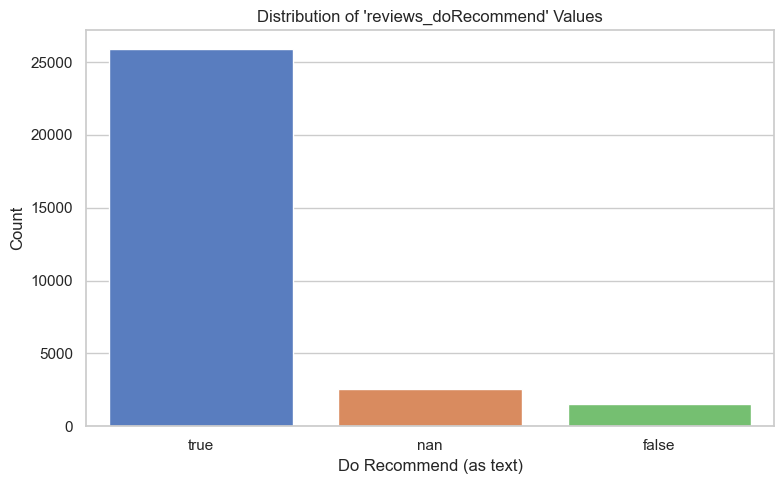

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x="reviews_doRecommend",
    y="count",
    data=recommend_counts,
    palette="muted"
)
plt.title("Distribution of 'reviews_doRecommend' Values")
plt.ylabel("Count")
plt.xlabel("Do Recommend (as text)")
plt.tight_layout()
plt.show()

In [ ]:
# Compute count and percentage
recommend_summary = (
    review_cleaned_doRecommend["reviews_doRecommend"]
    .value_counts(dropna=False)
    .reset_index()
)

recommend_summary.columns = ["reviews_doRecommend", "count"]
recommend_summary["percentage"] = (recommend_summary["count"] / len(review_cleaned_doRecommend)) * 100
recommend_summary

,reviews_doRecommend,count,percentage
0,true,25880,86.266667
1,nan,2570,8.566667
2,false,1550,5.166667


### Observations
*	The column is heavily imbalanced, with over 87% of values being true.
*	The signal it provides is too weak to add meaningful value in modeling.
*	The column does not provide additional granularity compared to reviews_rating (which is numerical) or user_sentiment (which is the modeling target for sentiment analysis).
*	A large portion of values (~7.5%) are missing compare to false values, making it less reliable.

We have decided to remove the reviews_doRecommend column from further modeling and analysis


In [ ]:
# Drop the 'reviews_doRecommend' column
review_cleaned.drop(columns=['reviews_doRecommend'], inplace=True)

# review_length column created during EDA, so droping it.
review_cleaned.drop(columns=['review_length'], inplace=True)

# Confirm the column was removed
print("Updated columns:")
print(review_cleaned.columns.tolist())

Updated columns:
['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment']


In [ ]:
review_cleaned.shape

(30000, 11)

## Handling NULL values

In [ ]:
# Checking null values with count and percentage
null_counts = review_cleaned.isnull().sum()
null_percentages = (null_counts / len(review_cleaned)) * 100

# Combine into a summary DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentages.round(2)
}).sort_values(by='Null Count', ascending=False)

# Filter null summary to only show columns with missing values (percentage > 0)
null_summary_filtered = null_summary[null_summary["Null Percentage"] > 0]
null_summary_filtered

,Null Count,Null Percentage
reviews_title,190,0.63
manufacturer,141,0.47
reviews_username,63,0.21
reviews_date,46,0.15


### Handling NULL values in `reviews_username`

The `reviews_username` column is a crucial identifier for individual users in the dataset. It plays a central role in building the recommendation system, which relies on user-product interactions.

From our null value analysis, we observe that:

- The null percentage in `reviews_username` is **only 0.20%**
- These rows lack key user identification information and cannot be used in user-based collaborative filtering

**Decision**: Drop rows with missing `reviews_username` to ensure reliability of recommendations and data integrity.

In [ ]:
# Check current nulls in reviews_username
null_user_count = review_cleaned["reviews_username"].isnull().sum()
total_rows = len(review_cleaned)
null_user_pct = (null_user_count / total_rows) * 100
print(f"rows before dropping: {len(review_cleaned)}")
print(f"Nulls in 'reviews_username': {null_user_count} ({null_user_pct:.2f}%)")

rows before dropping: 30000
Nulls in 'reviews_username': 63 (0.21%)


In [ ]:
# Drop rows where reviews_username is null
review_cleaned = review_cleaned[review_cleaned["reviews_username"].notnull()].copy()

# Confirm drop
print(f"Updated rows after dropping: {len(review_cleaned)}")

Updated rows after dropping: 29937


In [ ]:
review_cleaned.shape

(29937, 11)

### Handling NULL values in `reviews_title`

The `reviews_title` column contains short summaries of reviews written by users. While it can offer additional context, it is not essential for either the sentiment analysis model or the recommendation engine, which primarily depend on the `reviews_text` and `reviews_rating`.

From our null value audit:
- The column has **0.67% missing values**
- These missing values are minimal and **do not affect core modeling components**

**Decision**: We will **remove rows where `reviews_title` is null** to maintain consistency in the dataset.

In [ ]:
# Check how many rows have null reviews_title
null_title_count = review_cleaned["reviews_title"].isnull().sum()
total_rows = len(review_cleaned)
null_title_pct = (null_title_count / total_rows) * 100

print(f"rows before dropping: {len(review_cleaned)}")
print(f"Nulls in 'reviews_title': {null_title_count} ({null_title_pct:.2f}%)")

rows before dropping: 29937
Nulls in 'reviews_title': 189 (0.63%)


In [ ]:
# Drop those rows
review_cleaned = review_cleaned[review_cleaned["reviews_title"].notnull()].copy()

# Confirm removal
print(f"Updated dataset rows: {len(review_cleaned)}")
print(f"Remaining nulls in 'reviews_title': {review_cleaned['reviews_title'].isnull().sum()}")

Updated dataset rows: 29748
Remaining nulls in 'reviews_title': 0


In [ ]:
# Checking null values with count and percentage
null_counts = review_cleaned.isnull().sum()
null_percentages = (null_counts / len(review_cleaned)) * 100

# Combine into a summary DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentages.round(2)
}).sort_values(by='Null Count', ascending=False)

# Filter null summary to only show columns with missing values (Count > 0)
null_summary_filtered = null_summary[null_summary["Null Count"] > 0]
null_summary_filtered

,Null Count,Null Percentage
manufacturer,141,0.47
reviews_date,40,0.13
user_sentiment,1,0.00


### Handling NULL values in `user_sentiment`

In [ ]:
review_cleaned[review_cleaned["user_sentiment"].isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [ ]:
review_cleaned[review_cleaned["user_sentiment"].isna()]["reviews_text"].values[0]

'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

#### Manual update of missing `user_sentiment`

During data cleaning, I found that only **1 row** has missing `user_sentiment`.  
I am currently **reading this review manually** and assigning the correct label (Positive/Negative) based on the review text.

Since it is only 1 row, manual correction is preferred instead of dropping the row.


In [ ]:
review_cleaned.loc[review_cleaned["user_sentiment"].isna(), "user_sentiment"] = "Positive"

In [ ]:
# Checking null values with count and percentage
null_counts = review_cleaned.isnull().sum()
null_percentages = (null_counts / len(review_cleaned)) * 100

# Combine into a summary DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentages.round(2)
}).sort_values(by='Null Count', ascending=False)

# Filter null summary to only show columns with missing values (Count > 0)
null_summary_filtered = null_summary[null_summary["Null Count"] > 0]
null_summary_filtered

,Null Count,Null Percentage
manufacturer,141,0.47
reviews_date,40,0.13


### Handling `manufacturer` and `reviews_date` Columns

#### `manufacturer`
This column provides metadata about the producer of the product. While it might be useful in content-based filtering or brand analysis, our current system is based purely on:
- User ratings (`reviews_rating`)
- Review text (`reviews_text`)
- Sentiment labels (`user_sentiment`)

Hence, it does **not contribute** to either:
- Sentiment classification (text-based)
- Recommendation generation (user-item matrix based)

**Decision**: we don't need to handle the NULL values for them.

---

#### `reviews_date`
This column records the date a review was made. While this could be valuable for:
- Time-series modeling
- Trend analysis
- Temporal recommendation systems

Our project:
- Does **not include** time-aware features
- Has only **0.14% missing** in this column

**Decision**: we don't need to handle the NULL values for them.

In [ ]:
review_cleaned.shape

(29748, 11)

## Correcting `user_sentiment` Based on Ratings

In our dataset, the `user_sentiment` column was derived manually or heuristically.  
During EDA we noticed inconsistencies between `reviews_rating` and `user_sentiment`.

To improve label consistency, we will apply this rule:

### Correction Rule

- **If rating >= 3 → Positive (1)**  
- **If rating <= 2 → Negative (0)**  

This rule assumes that even a 3-star review indicates a neutral to positive sentiment.

---

In [ ]:
# for correcting the user sentiment according to rating
def update_review_sentiment(x):
  if x >= 3 :
    return 'Positive'
  elif x > 0 and x < 3  :
    return 'Negative'

In [ ]:
review_cleaned['user_sentiment'] = review_cleaned['reviews_rating'].apply(update_review_sentiment)

In [ ]:
review_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29748 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29748 non-null  object
 1   brand             29748 non-null  object
 2   categories        29748 non-null  object
 3   manufacturer      29607 non-null  object
 4   name              29748 non-null  object
 5   reviews_date      29708 non-null  object
 6   reviews_rating    29748 non-null  int64 
 7   reviews_text      29748 non-null  object
 8   reviews_title     29748 non-null  object
 9   reviews_username  29748 non-null  object
 10  user_sentiment    29748 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.7+ MB


In [ ]:
# Convert all the text columns to string for performing text operations
review_cleaned['brand'] = review_cleaned['brand'].astype(str)
review_cleaned['categories'] = review_cleaned['categories'].astype(str)
review_cleaned['manufacturer'] = review_cleaned['manufacturer'].astype(str)
review_cleaned['name'] = review_cleaned['name'].astype(str)
review_cleaned['reviews_text'] = review_cleaned['reviews_text'].astype(str)
review_cleaned['reviews_title'] = review_cleaned['reviews_title'].astype(str)
review_cleaned['reviews_username'] = review_cleaned['reviews_username'].astype(str)
review_cleaned['user_sentiment'] = review_cleaned['user_sentiment'].astype(str)

In [ ]:
review_cleaned.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [ ]:
review_cleaned.columns.tolist()

['id',
 'brand',
 'categories',
 'manufacturer',
 'name',
 'reviews_date',
 'reviews_rating',
 'reviews_text',
 'reviews_title',
 'reviews_username',
 'user_sentiment']

In [ ]:
review_cleaned.to_csv(data_directory + "sample30_cleand.csv", index=False)

In [ ]:
review_cleaned = pd.read_csv(data_directory + "sample30_cleand.csv")

In [ ]:
review_cleaned.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


### Combining `reviews_title` and `reviews_text`

To enrich the input for sentiment analysis, we combine both the `reviews_title` and `reviews_text` columns into a single column called `reviews_combined`.

This ensures that short but informative titles are not ignored during text preprocessing or model training. Titles are prefixed to the review text with a period separator.

**Example**:
- `reviews_title`: *"Great product"*
- `reviews_text`: *"Worked perfectly and delivery was fast"*
- `reviews_combined`: *"Great product. Worked perfectly and delivery was fast"*

In [ ]:
review_cleaned["reviews_text_title"] = (
    review_cleaned["reviews_title"].astype(str).str.strip()
    + ". "
    + review_cleaned["reviews_text"].astype(str).str.strip()
)

In [ ]:
review_cleaned.columns.tolist()

['id',
 'brand',
 'categories',
 'manufacturer',
 'name',
 'reviews_date',
 'reviews_rating',
 'reviews_text',
 'reviews_title',
 'reviews_username',
 'user_sentiment',
 'reviews_text_title']

# 3. Text preprocessing

In [ ]:
review_model_data = review_cleaned.copy()

In [ ]:
# Convert 'user_sentiment' to binary sentiment_label: Positive → 1, Negative → 0
review_model_data["user_sentiment"] = review_model_data["user_sentiment"].map({
    "Positive": 1,
    "Negative": 0
})

In [ ]:
review_model_data.columns.tolist()

['id',
 'brand',
 'categories',
 'manufacturer',
 'name',
 'reviews_date',
 'reviews_rating',
 'reviews_text',
 'reviews_title',
 'reviews_username',
 'user_sentiment',
 'reviews_text_title']

In [ ]:
review_model_data = review_model_data[['id','name','reviews_text_title', 'user_sentiment', 'reviews_rating']]

In [ ]:
review_model_data.shape

(29748, 5)

### Common functions for cleaning the text data

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Global objects
STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

# --- Text cleaning functions ---

def clean_special_characters(text, remove_digits=True):
    """Remove special characters from text"""
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

def lowercase_tokens(tokens):
    """Convert list of tokens to lowercase"""
    return [token.lower() for token in tokens]

def remove_punct_and_special_chars(tokens):
    """Remove punctuation and special characters from list of tokens"""
    return [
        clean_special_characters(re.sub(r'[^\w\s]', '', token))
        for token in tokens
        if clean_special_characters(re.sub(r'[^\w\s]', '', token)) != ''
    ]

def remove_stopwords(tokens):
    """Remove stopwords from list of tokens"""
    return [token for token in tokens if token not in STOPWORDS]

def stem_tokens(tokens):
    """Stem tokens using Lancaster Stemmer"""
    return [STEMMER.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    """Lemmatize tokens using WordNetLemmatizer (verb pos)"""
    return [LEMMATIZER.lemmatize(token, pos='v') for token in tokens]

def normalize_tokens(tokens):
    """Pipeline: lowercase -> punctuation removal -> stopword removal"""
    tokens = lowercase_tokens(tokens)
    tokens = remove_punct_and_special_chars(tokens)
    tokens = remove_stopwords(tokens)
    return tokens

def lemmatize_normalized(tokens):
    """Pipeline: lemmatize normalized tokens"""
    return lemmatize_tokens(tokens)

def clean_text(text):
    """ cleaning pipeline: raw text -> clean string """
    text = clean_special_characters(text)
    tokens = word_tokenize(text)

    tokens = normalize_tokens(tokens)
    tokens = lemmatize_normalized(tokens)

    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Text Preprocessing Pipeline

#### Pipeline Steps:

1. **Tokenize the text**
2. **Lowercase** all tokens
3. **Remove punctuation** and special characters
4. **Remove stopwords**
5. **Lemmatize tokens** using WordNet Lemmatizer (verb POS)
6. **Return cleaned text** as string

In [ ]:
# Apply cleaning to 'reviews_text_title' column
review_model_data['clean_lemmatized_text'] = review_model_data['reviews_text_title'].astype(str).apply(lambda x: clean_text(x))

### Top Words per Sentiment Class (Word Frequency Plot)

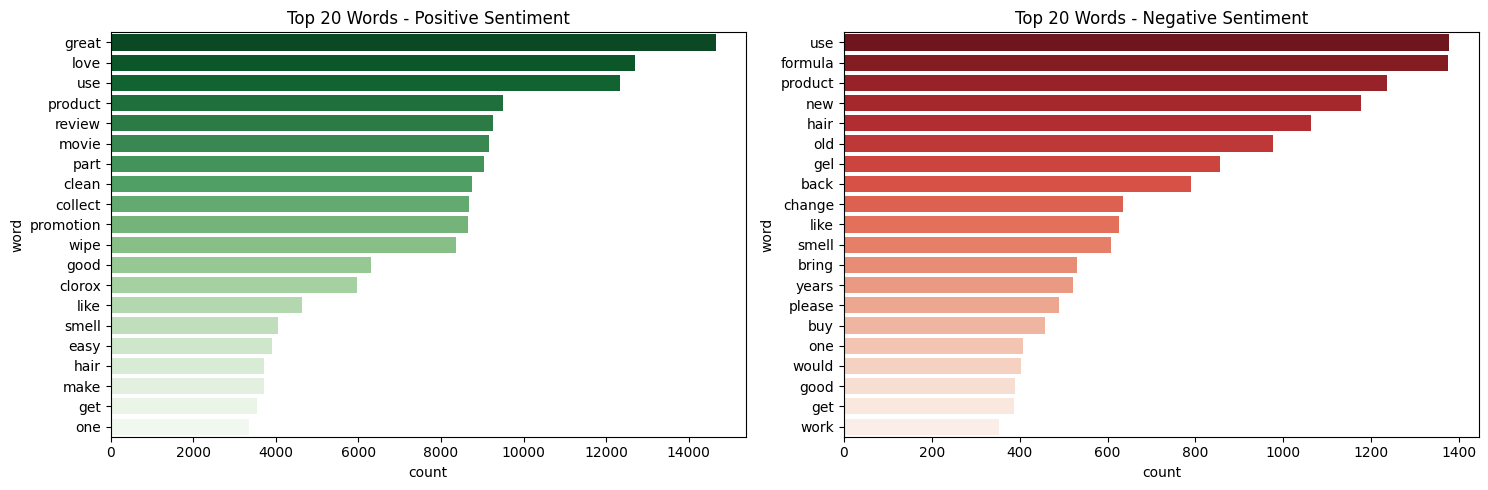

In [ ]:
# Get top words for each sentiment
def get_top_words(text_series, n=20):
    all_words = " ".join(text_series).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=["word", "count"])

top_pos = get_top_words(review_model_data[review_model_data["user_sentiment"] == 1]["clean_lemmatized_text"])
top_neg = get_top_words(review_model_data[review_model_data["user_sentiment"] == 0]["clean_lemmatized_text"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=top_pos, y="word", x="count", ax=axes[0], palette="Greens_r")
axes[0].set_title("Top 20 Words - Positive Sentiment")

sns.barplot(data=top_neg, y="word", x="count", ax=axes[1], palette="Reds_r")
axes[1].set_title("Top 20 Words - Negative Sentiment")

plt.tight_layout()
plt.show()

### Rating Sentiment Confusion Matrix

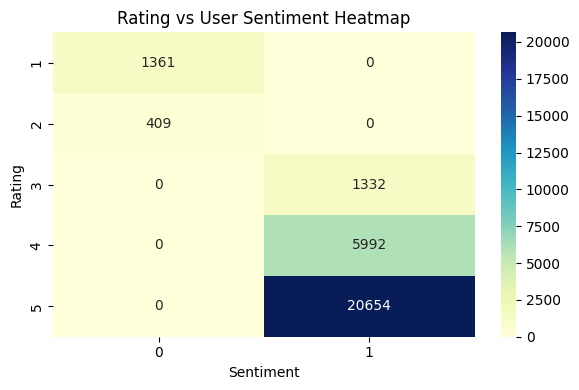

In [ ]:
conf_matrix = pd.crosstab(review_model_data["reviews_rating"], review_model_data["user_sentiment"])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Rating vs User Sentiment Heatmap")
plt.xlabel("Sentiment")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

In [ ]:
review_model_data.to_csv(data_directory + "sample30_model_cleand.csv", index=False)

In [ ]:
review_model_data = pd.read_csv(data_directory + "sample30_model_cleand.csv")

### Dividing the dataset into train and test data

In [ ]:
# Features and target
X = review_model_data["clean_lemmatized_text"]
y = review_model_data["user_sentiment"]

# Train-test split (stratify to preserve class ratio)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Feature extraction

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=10000)

# Fit-transform on training data and transform on test data
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# Output shapes for confirmation
X_train_tfidf.shape, X_test_tfidf.shape

((23798, 10000), (5950, 10000))

In [ ]:
# Get the TF-IDF feature names
feature_names = tfidf.get_feature_names_out()

# Convert to DataFrame for better visibility
import pandas as pd
tfidf_features_df = pd.DataFrame(feature_names, columns=["TF-IDF Feature"])

# Display the first 20 features
tfidf_features_df.head(20)

,TF-IDF Feature
0,aaron
1,ability
2,able
3,able clean
4,able find
5,able get
6,able go
7,able grab
8,able see
9,able use


In [ ]:
import pickle

In [ ]:
pickle.dump(tfidf, open(pickle_directory + 'tfidf.pkl','wb'))

In [ ]:
# Check before SMOTE
print("Before handling imbalance:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# Check after
print("After handling imbalance:", Counter(y_train_balanced))

Before handling imbalance: Counter({1: 22382, 0: 1416})
After handling imbalance: Counter({1: 22382, 0: 22382})


# 5. Training text classification model
- Logistic Regression
- Naive Bayes
- Random Forest Classifer
- XGBoost
#### Choose the best model with hyperparameter tuning

In [ ]:
# Function to compute evaluation metrics
# Function to compute evaluation metrics (updated with ROC AUC)
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    # Specificity calculation
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # ROC AUC score (for binary labels)
    roc_auc = roc_auc_score(y_true, y_pred)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity/Recall': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Store all metrics here
all_metrics = []

In [ ]:
def evaluates_model_metrics(y_test, y_pred, model_name, metrics_file_path= pickle_directory + "global_metrics.csv"):
    """
    Evaluates the model using evaluate_model() and saves result to CSV.
    Returns updated global_metrics_df DataFrame.
    """
    # Compute metrics
    metrics_result = evaluate_model(y_test, y_pred, model_name)

    # Check if file exists — load to DataFrame
    if os.path.exists(metrics_file_path):
        existing_df = pd.read_csv(metrics_file_path)
        combined_df = pd.concat([existing_df, pd.DataFrame([metrics_result])], ignore_index=True)
    else:
        combined_df = pd.DataFrame([metrics_result])

    # Save updated CSV
    combined_df.to_csv(metrics_file_path, index=False)

    # Return updated DataFrame
    return combined_df

## Logistic Regression

In [ ]:
# Initialize and train the model on balanced data
lr_model = LogisticRegression()
lr_model.fit(X_train_balanced, y_train_balanced)

# Predict on original test data (not oversampled)
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluation metrics
global_metrics_df = evaluates_model_metrics(y_test, y_pred_lr, "Logistic Regression")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721


In [ ]:
pickle.dump(lr_model, open(pickle_directory + 'Logistic_Regression.pkl','wb'))

## Naive Bayes Training & Evaluation

In [ ]:
# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)

MultinomialNB()

In [ ]:
# Predict on test data
y_pred_nb = nb_model.predict(X_test_tfidf)

global_metrics_df = evaluates_model_metrics(y_test, y_pred_nb, "Naive Bayes")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071


In [ ]:
pickle.dump(nb_model, open(pickle_directory + 'Naive_Bayes.pkl','wb'))

## Random Forest Model Training and Evaluation

In [ ]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [ ]:
pickle.dump(rf_model, open(pickle_directory + 'Random_Forest.pkl','wb'))

## Random Forest with Hyper Parameter Tuning v1

In [ ]:
# Define the model
rf_m_v1 = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid_rf_v1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Setup GridSearchCV
grid_search_rf_v1 = GridSearchCV(estimator=rf_m_v1,
                           param_grid=param_grid_rf_v1,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

# Fit the model on balanced data
grid_search_rf_v1.fit(X_train_balanced, y_train_balanced)

# Best model
rf_v1 = grid_search_rf_v1.best_estimator_
print("Best Parameters:\n", grid_search_rf_v1.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters:
 {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Predict on test set using the best estimator
y_pred_rf_v1 = rf_v1.predict(X_test_tfidf)

# Evaluation metrics
global_metrics_df = evaluates_model_metrics(y_test, y_pred_rf_v1, "Random Forest (Tuned v1)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947


## Random Forest with Hyper Parameter Tuning - v2

In [ ]:
rf_m_v2 = RandomForestClassifier(random_state=42)

param_grid_rf_v2 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

grid_search_rf_v2 = GridSearchCV(rf_m_v2,
                    param_grid=param_grid_rf_v2,
                    scoring='recall',
                    cv=5,
                    n_jobs=-1,
                    verbose=2)

grid_search_rf_v2.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  11.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2)

In [ ]:
rf_v2 = grid_search_rf_v2.best_estimator_
y_pred_rf_v2= rf_v2.predict(X_test_tfidf)

# Evaluation metrics
global_metrics_df = evaluates_model_metrics(y_test, y_pred_rf_v2, "Random Forest (Tuned v2)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763


In [ ]:
pickle.dump(rf_v2, open(pickle_directory + 'RandomForestTunedv2.pkl','wb'))

## Random Forest with Hyper Parameter Tuning - v3

In [ ]:
# Define hyperparameter
param_grid_rf_v3 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize RandomForest and GridSearchCV
rf_m_v3 = RandomForestClassifier(random_state=42)

grid_search_rf_v3 = GridSearchCV(rf_m_v3,
                    param_grid=param_grid_rf_v3,
                    scoring='recall',
                    cv=5,
                    n_jobs=-1,
                    verbose=2)

# Fit on training data
grid_search_rf_v3.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.1s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='recall', verbose=2)

In [ ]:
# Best model and evaluation
rf_v3 = grid_search_rf_v3.best_estimator_
y_pred_rf_v3 = rf_v3.predict(X_test_tfidf)

# Evaluation metrics
global_metrics_df = evaluates_model_metrics(y_test, y_pred_rf_v3, "Random Forest (Tuned v3)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765


In [ ]:
pickle.dump(rf_v3, open(pickle_directory + 'RandomForestTunedv3.pkl','wb'))

## XGBoost

In [ ]:
# Train the XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_balanced, y_train_balanced)
print()

In [ ]:
# Predict on test data
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluation metrics
global_metrics_df = evaluates_model_metrics(y_test, y_pred_rf_v3, "XGBoost")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
6,XGBoost,0.960000,0.981237,0.624294,0.976351,0.978788,0.802765


In [ ]:
pickle.dump(xgb_model, open(pickle_directory + 'XGBoost.pkl','wb'))

## XGBoost hyperparameters Tune v1

In [ ]:
param_grid_xg_v1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'tree_method': ['gpu_hist']
}

xgb_model_v1 = XGBClassifier(random_state=42, use_label_encoder=False, device="cuda")
grid_search_xg_v1 = GridSearchCV(xgb_model_v1,
                           param_grid=param_grid_xg_v1,
                           scoring='f1',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [ ]:
grid_search_xg_v1.fit(X_train_balanced, y_train_balanced)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0],
                         'tree_method': ['gpu_hist']},
             scoring='f1', verbose=2)

In [ ]:
print("Best params:", grid_search_xg_v1.best_params_)
print("Best score (F1):", grid_search_xg_v1.best_score_)

# Re-train best model
best_xgb_model_v1 = grid_search_xg_v1.best_estimator_
y_pred_xgb_v1 = best_xgb_model_v1.predict(X_test_tfidf)

# Evaluation metrics
global_metrics_df = evaluates_model_metrics(y_test, y_pred_xgb_v1, "XGBoost (Tuned - v1)")
global_metrics_df

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
Best score (F1): 0.7238939069450397


,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
6,XGBoost,0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
7,XGBoost (Tuned - v1),0.752605,0.760901,0.621469,0.969490,0.852623,0.691185


In [ ]:
pickle.dump(best_xgb_model_v1, open(pickle_directory + 'XGBoostV1.pkl','wb'))

## XGBoost hyperparameters Tune v2

In [ ]:
# Define the model
xgb_model_v2 = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

# Define parameter grid
param_grid_v2 = {
    'n_estimators': [200, 400, 600],
    'max_depth': [6, 10, 15],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 1, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# GridSearch
grid_search_xgb_v2 = GridSearchCV(
    estimator=xgb_model_v2,
    param_grid=param_grid_v2,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)


In [ ]:
# Fit
grid_search_xgb_v2.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     predictor='gpu_predictor', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [6, 10, 15],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [200, 400, 600],
                         'subsample': [0.8, 1]},
             scoring='f1', verbose=2)

In [ ]:
# Best model
best_xgb_model_v2 = grid_search_xgb_v2.best_estimator_

# Predict
y_pred_xgb_v2 = best_xgb_model_v2.predict(X_test_tfidf)

global_metrics_df = evaluates_model_metrics(y_test, y_pred_xgb_v2, "XGBoost (Tuned v2)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
6,XGBoost,0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
7,XGBoost (Tuned - v1),0.752605,0.760901,0.621469,0.969490,0.852623,0.691185
8,XGBoost (Tuned v2),0.776134,0.787527,0.596045,0.968571,0.868717,0.691786


In [ ]:
pickle.dump(best_xgb_model_v2, open(pickle_directory + 'XGBoostv2.pkl','wb'))

## Tune TF_IDF for pipeline

In [ ]:
from imblearn.pipeline import Pipeline

In [ ]:
tfidf_pipeline = TfidfVectorizer(
        ngram_range=(1,3),
        max_features=20000,
        sublinear_tf=True,
        stop_words='english',
        min_df=5
    )

smote_pipeline = SMOTE(random_state=42)

## XGBoost with Hyper Parameter Tuning - v3

In [ ]:
xgb_v3 = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [ ]:
# Param grid
param_grid_xgb_v3_pipeline = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [6, 8],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__gamma': [0, 0.1],
    'xgb__scale_pos_weight': [1, 2]
}

In [ ]:
# Pipeline
xgb_pipeline_v3 = Pipeline([
    ('tfidf', tfidf_pipeline),
    ('smote', smote_pipeline),
    ('xgb', xgb_v3)
])

# GridSearch
grid_pipeline_xgb_v3 = GridSearchCV(
    xgb_pipeline_v3,
    param_grid=param_grid_xgb_v3_pipeline,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [ ]:
# Fit
grid_pipeline_xgb_v3.fit(X_train_raw, y_train)

# Best
best_pipeline = grid_pipeline_xgb_v3.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
# Best model and evaluation
xgb_v4 = grid_pipeline_xgb_v3.best_estimator_

y_pred_xgb_v4 = xgb_v4.predict(X_test_raw)

global_metrics_df = evaluates_model_metrics(y_test, y_pred_xgb_v4, "XGBoost (Tuned v3)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
6,XGBoost,0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
7,XGBoost (Tuned - v1),0.752605,0.760901,0.621469,0.969490,0.852623,0.691185
8,XGBoost (Tuned v2),0.776134,0.787527,0.596045,0.968571,0.868717,0.691786
9,XGBoost (Tuned v3),0.541008,0.528056,0.745763,0.970443,0.683949,0.636909


## LogisticRegression with Hyper Parameter Tuning - v1

In [ ]:
logreg_v1 = LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    )

In [ ]:
# Define pipeline
pipeline_smote_logreg = Pipeline([
    ('tfidf', tfidf_pipeline),
    ('smote', smote_pipeline),
    ('logreg', logreg_v1)
])

# Define param grid
param_grid_smote_logreg_v1 = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

# GridSearch
grid_smote_logreg_v1 = GridSearchCV(
    pipeline_smote_logreg,
    param_grid=param_grid_smote_logreg_v1,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)


In [ ]:
# Fit
grid_smote_logreg_v1.fit(X_train_raw, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=20000,
                                                        min_df=5,
                                                        ngram_range=(1, 3),
                                                        stop_words='english',
                                                        sublinear_tf=True)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 10],
                         'logreg__penalty': ['l1', 'l2']},
             scoring='recall', verbose=2)

In [ ]:
# Best model and evaluation
y_pred_logreg_pipeline_v1 = grid_smote_logreg_v1.predict(X_test_raw)

global_metrics_df = evaluates_model_metrics(y_test, y_pred_logreg_pipeline_v1, "LogisticRegression (Tuned v1)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
6,XGBoost,0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
7,XGBoost (Tuned - v1),0.752605,0.760901,0.621469,0.969490,0.852623,0.691185
8,XGBoost (Tuned v2),0.776134,0.787527,0.596045,0.968571,0.868717,0.691786
9,XGBoost (Tuned v3),0.541008,0.528056,0.745763,0.970443,0.683949,0.636909


In [ ]:
logreg_v2 = LogisticRegression(
        penalty='l2',
        solver='saga',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )

In [ ]:
# Define pipeline

pipeline_smote_logreg_v2 = Pipeline([
    ('tfidf', tfidf_pipeline),
    ('smote', smote_pipeline),
    ('logreg', logreg_v2)
])

# Param grid
param_grid_logreg_v2 = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV
grid_logreg_v2 = GridSearchCV(
    pipeline_smote_logreg_v2,
    param_grid=param_grid_logreg_v2,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

In [ ]:
# Fit
grid_logreg_v2.fit(X_train_raw, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=20000,
                                                        min_df=5,
                                                        ngram_range=(1, 3),
                                                        stop_words='english',
                                                        sublinear_tf=True)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1, param_grid={'logreg__C': [0.01, 0.1, 1, 10, 100]},
             scoring='f1', verbose=2)

In [ ]:

# Best model and evaluation
logreg_pipeline_model_v2 = grid_logreg_v2.best_estimator_

y_pred_logreg_pipeline_v2 = logreg_pipeline_model_v2.predict(X_test_raw)

global_metrics_df = evaluates_model_metrics(y_test, y_pred_logreg_pipeline_v2, "LogisticRegression (Tuned v2)")
global_metrics_df

,Model,Accuracy,Sensitivity/Recall,Specificity,Precision,F1 Score,ROC AUC
0,Logistic Regression,0.962521,0.971408,0.822034,0.988543,0.979901,0.896721
1,Naive Bayes,0.922521,0.927984,0.836158,0.988954,0.957500,0.882071
2,Random Forest,0.972269,0.993746,0.632768,0.977157,0.985381,0.813257
3,Random Forest (Tuned v1),0.973277,0.997498,0.590395,0.974681,0.985958,0.793947
4,Random Forest (Tuned v2),0.970588,0.998928,0.522599,0.970655,0.984588,0.760763
5,Random Forest (Tuned v3),0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
6,XGBoost,0.960000,0.981237,0.624294,0.976351,0.978788,0.802765
7,XGBoost (Tuned - v1),0.752605,0.760901,0.621469,0.969490,0.852623,0.691185
8,XGBoost (Tuned v2),0.776134,0.787527,0.596045,0.968571,0.868717,0.691786
9,XGBoost (Tuned v3),0.541008,0.528056,0.745763,0.970443,0.683949,0.636909


In [ ]:
pickle.dump(y_pred_logreg_pipeline_v2, open(pickle_directory + 'LogisticRegressionV2.pkl','wb'))

# Building a Recommendation System

We will build the below two recommendation systems
1. User-based recommendation system
2. Item-based recommendation system

Once built, we will analyze the recommendation systems and select the one that is best suited in this case.
Once we get the best-suited recommendation system, the next task will be to recommend 20 products that a user is most likely to purchase based on the ratings.

In [ ]:
review_recomm = pd.read_csv(data_directory + "sample30.csv")

In [ ]:
# Extract only the required columns
recommendation_data = review_recomm[["reviews_username", "name", "reviews_rating"]]

# Drop rows with missing values safely
recommendation_data = recommendation_data.dropna(subset=["reviews_username", "name", "reviews_rating"])

# Preview cleaned data
recommendation_data.head()

,reviews_username,name,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1


In [ ]:
len(review_recomm['name'].unique())

271

In [ ]:
recommendation_data.shape

(29937, 3)

In [ ]:
# Test and Train split of the dataset.
train, test = train_test_split(recommendation_data, test_size=0.3, random_state=42)

print('train shape = ',train.shape)
print('test shape = ',test.shape)

train shape =  (20955, 3)
test shape =  (8982, 3)


In [ ]:
# Copy the train dataset for dummy matrices
dummy_train = train.copy()

# Create dummy train matrix (rated = 0, unrated = 1 after pivot)
# First, replace actual ratings with 0 (rated)
dummy_train['dummy_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x >=1 else 1)

# Create dummy train matrix in pivot form, missing = 1 (unrated)
dummy_train_matrix = dummy_train.reset_index().pivot_table(
    index='reviews_username',
    columns='name',
    values='dummy_rating',
    aggfunc='mean'
).fillna(1)

# Show shape and preview of both dummy matrices
dummy_train_matrix_shape = dummy_train_matrix.shape
dummy_train_matrix_shape

(18275, 256)

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are name and the rows are reviews_username.
user_item_train_matrix = train.reset_index().pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc='mean'
).fillna(0)

# Preview
print("Shape:", user_item_train_matrix.shape)
user_item_train_matrix.head()

Shape: (18275, 256)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(user_item_train_matrix, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [ ]:
user_correlation.shape

(18275, 18275)

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are id and the rows are reviews_username.
user_item_train_matrix = train.reset_index().pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc='mean'
)

In [ ]:
# Subtract user mean to center ratings (Adjusted Cosine)
user_mean_adjusted = np.nanmean(user_item_train_matrix, axis=1)
user_item_adjusted_matrix_centered = (user_item_train_matrix.T - user_mean_adjusted).T

In [ ]:
# Fill NaNs with 0 to prepare for similarity calculation
user_item_adjusted_matrix_centered_filled = user_item_adjusted_matrix_centered.fillna(0)

# Compute adjusted cosine similarity
user_similarity_adjusted = 1 - pairwise_distances(user_item_adjusted_matrix_centered_filled, metric='cosine')
user_similarity_adjusted[np.isnan(user_similarity_adjusted)] = 0

In [ ]:
user_similarity_adjusted

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
user_similarity_adjusted[user_similarity_adjusted < 0] = 0

# Predict ratings using dot product of similarity and raw ratings
user_predicted_ratings = np.dot(user_similarity_adjusted, user_item_train_matrix.fillna(0))

# Mask already rated products using dummy_train
user_final_rating = np.multiply(user_predicted_ratings, dummy_train_matrix)

# Show preview
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,3.653338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.43125,...,1.154701,0.0,0.0,0.0,1.24929,0.0,0.0,3.596262,2.0,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0
02dakota,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0


## Prediction - User User

In [ ]:
# Filter common users present in both test set and top_users
common_test_users_ubcf = test[test['reviews_username'].isin(train.reviews_username)]
common_test_users_ubcf.shape

(2051, 3)

In [ ]:
common_test_users_ubcf.head()

,reviews_username,name,reviews_rating
12875,jessica,Clorox Disinfecting Wipes Value Pack Scented 1...,5
21657,romance318,Nexxus Exxtra Gel Style Creation Sculptor,1
23320,countprice,Godzilla 3d Includes Digital Copy Ultraviolet ...,3
21505,farbar,Nexxus Exxtra Gel Style Creation Sculptor,1
29216,baronesscountess,L'or233al Paris Elvive Extraordinary Clay Reba...,4


In [ ]:
# Create user-item matrix from common users in test set
common_test_users_ubcf_matrix = common_test_users_ubcf.reset_index().pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc='mean'
)

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_similarity_adjusted_df = pd.DataFrame(user_similarity_adjusted)

In [ ]:
user_similarity_adjusted_df['reviews_username'] = user_item_adjusted_matrix_centered.index
user_similarity_adjusted_df.set_index('reviews_username',inplace=True)
user_similarity_adjusted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common_test_users_ubcf.reviews_username.tolist()

user_similarity_adjusted_df.columns = user_item_adjusted_matrix_centered.index.tolist()


user_similarity_adjusted_df_1 =  user_similarity_adjusted_df[user_similarity_adjusted_df.index.isin(list_name)]
user_similarity_adjusted_df_1.shape

(1693, 18275)

In [ ]:
user_similarity_adjusted_df_2 = user_similarity_adjusted_df_1.T[user_similarity_adjusted_df_1.T.index.isin(list_name)]

In [ ]:
user_similarity_adjusted_df_3 = user_similarity_adjusted_df_2.T

In [ ]:
user_similarity_adjusted_df_3.head()

,1234,1234567,123charlie,1943,1witch,4 rooms 1 dog lotsa fur,85lisa,a hutch,aac06002,aalyah,...,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_similarity_adjusted_df_3.shape

(1693, 1693)

In [ ]:
user_similarity_adjusted_df_3[user_similarity_adjusted_df_3 < 0] = 0

common_user_predicted_ratings = np.dot(user_similarity_adjusted_df_3, common_test_users_ubcf_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dummy_test_user_ubcf = common_test_users_ubcf.copy()

dummy_test_user_ubcf['reviews_rating'] = dummy_test_user_ubcf['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test_user_ubcf_matrix = dummy_test_user_ubcf.pivot_table(index='reviews_username', columns='name', values='reviews_rating', aggfunc='mean').fillna(0)

In [ ]:
dummy_test_user_ubcf_matrix.shape

(1693, 140)

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test_user_ubcf_matrix)

In [ ]:
common_user_predicted_ratings.shape

(1693, 140)

In [ ]:
X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))


In [ ]:
common_ = common_test_users_ubcf.reset_index().pivot_table(index='reviews_username', columns='name', values='reviews_rating', aggfunc='mean')

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse_ubcf = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_ubcf)

2.551419404666111


## Item based similarity

In [ ]:
item_item_train_matrix = train.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='name', aggfunc='mean').T
item_item_train_matrix.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the Item rating for each item for using the Adujsted Cosine

In [ ]:
item_item_train_matrix_mean = np.nanmean(item_item_train_matrix, axis=1)
item_item_train_matrix_normalized = (item_item_train_matrix.T - item_item_train_matrix_mean).T

Finding the cosine similarity using pairwise distances approach

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(item_item_train_matrix_normalized.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00559589  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00559589  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [ ]:
item_correlation[item_correlation <0 ] = 0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
item_predicted_ratings = np.dot((item_item_train_matrix.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.00000000e+00, 3.65536115e-02, 0.00000000e+00, ...,
        6.04167387e-03, 2.52660845e-05, 0.00000000e+00],
       [0.00000000e+00, 3.15543856e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.25906426e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.22214474e-05, 1.32205039e-03, 0.00000000e+00],
       [0.00000000e+00, 4.44412303e-02, 0.00000000e+00, ...,
        1.00694564e-02, 4.21101408e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.57771579e-05, 1.05764031e-03, 0.00000000e+00]])

In [ ]:
item_predicted_ratings.shape

(18275, 256)

### Filtering the rating only for the items not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train_matrix)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.036554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014704,...,0.032108,0.0,0.0,0.0,0.016342,0.0,0.0,0.006042,0.000025,0.0
01impala,0.0,0.031554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017785,...,0.000000,0.0,0.0,0.0,0.003641,0.0,0.0,0.000000,0.000000,0.0
02dakota,0.0,0.052591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029642,...,0.000000,0.0,0.0,0.0,0.006069,0.0,0.0,0.000000,0.000000,0.0
02deuce,0.0,0.042073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023714,...,0.000000,0.0,0.0,0.0,0.004855,0.0,0.0,0.000000,0.000000,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000082,0.001322,0.0


### Prediction - Item Item

In [ ]:
common_test_items =  test[test.name.isin(train.name)]
common_test_items.shape

(8966, 3)

In [ ]:
common_item_based_matrix = common_test_items.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='name', aggfunc='mean').T
common_item_based_matrix.shape

(195, 8318)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df['name'] = item_item_train_matrix_normalized.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common_test_items.name.tolist()

item_correlation_df.columns = item_item_train_matrix_normalized.index.tolist()


item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_1.shape

(195, 256)

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

In [ ]:
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz",...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df_3[item_correlation_df_3 < 0] = 0


In [ ]:
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.25906426e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.32205039e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
common_item_predicted_ratings.shape

(195, 8318)

In [ ]:
dummy_test_item = common_test_items.copy()
dummy_test_item['reviews_rating'] = dummy_test_item['reviews_rating'].apply(lambda x: 1 if x >= 1 else 0)

dummy_test_item_matrix = dummy_test_item.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='name', aggfunc='mean').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test_item_matrix)

# The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.
common_ = dummy_test_item.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='name', aggfunc='mean').T

In [ ]:
X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)

MinMaxScaler(feature_range=(1, 5))

In [ ]:
y = (scaler.transform(X))
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  1., nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
# Finding total non-NaN value
total_non_nan_items = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan_items)**0.5
print(rmse_item_item)

0.7990026141277146


In [ ]:
pickle.dump(user_final_rating, open(pickle_directory + 'user_final_rating.pkl','wb'))

In [ ]:
pickle.dump(item_final_rating, open(pickle_directory + 'item_final_rating.pkl','wb'))

In [ ]:
print(f"Item-Item Collaborative Filtering RMSE: {rmse_item_item:.4f}")
print(f"User-User Collaborative Filtering RMSE: {rmse_ubcf:.4f}")

Item-Item Collaborative Filtering RMSE: 0.7990
User-User Collaborative Filtering RMSE: 2.5514


### RMSE Comparison: Item-Item vs User-User Collaborative Filtering

#### Interpretation:

- **Root Mean Squared Error (RMSE)** measures how much the predicted ratings deviate from the actual ratings.
- A **lower RMSE** indicates better performance — the predictions are closer to the true ratings.

#### Conclusion:

- In this case, **Item-Item Collaborative Filtering** clearly outperforms **User-User Collaborative Filtering**.
    - IICF RMSE: `0.7990`
    - UCF RMSE: `2.5514`
- This suggests that for this dataset, **product similarity** (**item-item**) is more reliable for predicting user preferences than user similarity (user-user).
- **Recommendation**: Proceed with **Item-Item** CF for production or next stages.

# Validate Recommendation System

In [4]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Global objects
STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

# --- Text cleaning functions ---

def clean_special_characters(text, remove_digits=True):
    """Remove special characters from text"""
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

def lowercase_tokens(tokens):
    """Convert list of tokens to lowercase"""
    return [token.lower() for token in tokens]

def remove_punct_and_special_chars(tokens):
    """Remove punctuation and special characters from list of tokens"""
    return [
        clean_special_characters(re.sub(r'[^\w\s]', '', token))
        for token in tokens
        if clean_special_characters(re.sub(r'[^\w\s]', '', token)) != ''
    ]

def remove_stopwords(tokens):
    """Remove stopwords from list of tokens"""
    return [token for token in tokens if token not in STOPWORDS]

def stem_tokens(tokens):
    """Stem tokens using Lancaster Stemmer"""
    return [STEMMER.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    """Lemmatize tokens using WordNetLemmatizer (verb pos)"""
    return [LEMMATIZER.lemmatize(token, pos='v') for token in tokens]

def normalize_tokens(tokens):
    """Pipeline: lowercase -> punctuation removal -> stopword removal"""
    tokens = lowercase_tokens(tokens)
    tokens = remove_punct_and_special_chars(tokens)
    tokens = remove_stopwords(tokens)
    return tokens

def lemmatize_normalized(tokens):
    """Pipeline: lemmatize normalized tokens"""
    return lemmatize_tokens(tokens)

def clean_text(text):
    """ cleaning pipeline: raw text -> clean string """
    text = clean_special_characters(text)
    tokens = word_tokenize(text)

    tokens = normalize_tokens(tokens)
    tokens = lemmatize_normalized(tokens)

    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
# Load Pickles
final_rating = pickle.load(open(pickle_directory + 'item_final_rating.pkl', 'rb'))
tfidf = pickle.load(open(pickle_directory + 'tfidf.pkl', 'rb'))
model = pickle.load(open(pickle_directory + 'Logistic_Regression.pkl', 'rb'))

product_df = pd.read_csv(data_directory + 'sample30_cleand.csv')

# ---- Step 1: Get top 20 UBCF products ----

def get_top_20_products(user_id, final_rating, verbose=True):
    if user_id not in final_rating.index:
        if verbose:
          print(f"User '{user_id}' not found in final_rating.")
        return []

    top_20_ids = final_rating.loc[user_id].sort_values(ascending=False).head(20).index.tolist()
    return top_20_ids

# ---- Step 2: Predict positive sentiment for all reviews ----

def compute_sentiment_probabilities(text_series, sentimodel, tfidf_vectorizer, verbose=True):
    clean_texts = text_series.astype(str)
    clean_texts = clean_texts.apply(lambda x: clean_text(x))
    tfidf_input = tfidf_vectorizer.transform(clean_texts)
    sentiment_probs = sentimodel.predict_proba(tfidf_input)
    pos_probs = sentiment_probs[:, 1]
    return pos_probs

# ---- Step 3: Aggregate average sentiment score ----

def aggregate_sentiment_scores(reviews_df, verbose=True):
    summary = reviews_df.groupby('name')['positive_sentiment_prob'].mean().reset_index()
    summary = summary.rename(columns={'positive_sentiment_prob': 'avg_positive_sentiment'})
    return summary

# ---- Step 4: Build top 5 recommendations DataFrame ----

def build_top_5_df(review_df, top_5_ids, sentiment_summary, verbose=True):
    top_5_df = review_df[review_df['name'].isin(top_5_ids)][['id', 'name', 'brand', 'categories']].drop_duplicates()
    top_5_df = pd.merge(top_5_df, sentiment_summary, on='name', how='left')
    return top_5_df

# ---- Main function: Recommend Top 5 ----

def recommend_top_products(user_id, final_rating, review_df, sentimodel, tfidf_vectorizer, verbose=True):
    # 1. Get top 20 UBCF
    top_20_ids = get_top_20_products(user_id, final_rating, verbose)
    if verbose:
      print(f"Top 20 product IDs for user '{user_id}': {top_20_ids}")
    if not top_20_ids:
        return pd.DataFrame(columns=['id', 'name', 'brand', 'categories', 'avg_positive_sentiment'])

    # 2. Filter reviews
    candidate_reviews = review_df[review_df['name'].isin(top_20_ids)].copy()
    # 3. Compute sentiment probabilities
    candidate_reviews['positive_sentiment_prob'] = compute_sentiment_probabilities(
        candidate_reviews['reviews_text'],
        sentimodel,
        tfidf_vectorizer,
        verbose
    )

    # 4. Aggregate sentiment
    sentiment_summary = aggregate_sentiment_scores(candidate_reviews, verbose)

    # 5. Top 5 product IDs
    top_5_ids = sentiment_summary.sort_values(by='avg_positive_sentiment', ascending=False).head(5)['name']

    # 6. Build top 5 DataFrame
    top_5_df = build_top_5_df(review_df, top_5_ids, sentiment_summary, verbose)
    return top_5_df


def recommend_products(user_id, verbose=True):
    """
    Recommend top 5 products for a given user based on UBCF and sentiment analysis.

    Args:
        user_id (str): The user ID for whom to recommend products.

    Returns:
        pd.DataFrame: DataFrame containing top 5 recommended products with their details.
    """
    return recommend_top_products(user_id, final_rating, product_df, model, tfidf, verbose)

# Verify Recommendation System

### Check Overlap: Recommended Products vs. Already Rated Products

When building a **User-Based Collaborative Filtering (UBCF)** or **Sentiment-based Recommendation System**,  
it is important to verify whether the recommended products have already been rated by the user.  
If we recommend products the user already knows, the experience is not very useful.

The function below helps us automatically check:

- What products were recommended  
- What products the user already rated  
- The overlap — if any — between the two lists  

In [6]:
def check_overlap_rated_vs_recommended(product_df, top_product, username):
    """
    Check which recommended products have already been rated by the user.

    Args:¬
        product_df (pd.DataFrame): The main product dataframe
        top_product (pd.DataFrame): The DataFrame with top recommended products (should have 'name' column)
        username (str): The username to check

    Returns:
        List of overlapping product names (if any)
    """
    rated_products = product_df[product_df['reviews_username'] == username]['name'].unique()
    recommended = top_product['name'].tolist()

    overlap = list(set(recommended).intersection(set(rated_products)))

    print(f"\n User '{username}' rated {len(rated_products)} unique products.")
    print(f" Recommended top {len(recommended)} products.")
    print(f" Overlapping products (already rated by user): {len(overlap)}")

    if overlap:
        print("Overlap ->", overlap)
    else:
        print("No overlap - recommended products are new to user!")

    return overlap

### Sentiment Distribution of Recommended Products

When recommending products to a user, it is often useful to analyze:

- How many reviews for each product are Positive vs. Negative  
- The percentage breakdown (% Positive vs % Negative)  
- Whether highly recommended products really have strong positive reviews  

The function below helps compute this analysis for **any list of recommended products** (like top_product['name'] list).


In [7]:
def sentiment_distribution_for_products(product_df, top_product_df):
    """
    Computes Positive vs Negative sentiment % for a given list of products.

    Args:
        product_df (pd.DataFrame): The full product dataframe (must have 'name' and 'user_sentiment')
        top_product_df (pd.DataFrame): DataFrame with 'name' column (recommended products)

    Returns:
        pd.DataFrame: Sentiment summary per product with counts and percentages
    """
    # Step 1: Group and count sentiments
    summary_df = (
        product_df[product_df['name'].isin(top_product_df['name'])]
        .groupby(['name', 'user_sentiment'])
        .size()
        .reset_index(name='count')
    )

    # Step 2: Pivot
    pivot_df = summary_df.pivot_table(index='name', columns='user_sentiment', values='count', fill_value=0)

    # Step 3: Rename columns (ensure consistent order)
    columns = ['Negative', 'Positive']
    for col in columns:
        if col not in pivot_df.columns:
            pivot_df[col] = 0  # In case one label is missing

    pivot_df = pivot_df[columns]

    # Step 4: Calculate totals and percentages
    pivot_df['Total'] = pivot_df['Positive'] + pivot_df['Negative']
    pivot_df['% Positive'] = (pivot_df['Positive'] / pivot_df['Total']) * 100
    pivot_df['% Negative'] = (pivot_df['Negative'] / pivot_df['Total']) * 100

    # Step 5: Sort by % Positive (optional)
    pivot_df_sorted = pivot_df.sort_values(by='% Positive', ascending=False)

    return pivot_df_sorted[['Positive', 'Negative', 'Total', '% Positive', '% Negative']]

In [8]:
def validate_category_match(username, top_product, product_df):
    """
    Compare categories of recommended products vs categories user has rated positively.
    Displays % matching categories in pretty and readable way.
    """
    # Extract liked categories from positive reviews
    user_positive_df = product_df[
        (product_df['reviews_username'] == username) &
        (product_df['user_sentiment'] == 'Positive')
    ][['categories']]

    user_categories = (
        user_positive_df['categories']
        .dropna()
        .apply(lambda x: [cat.strip() for cat in x.split(",")])
        .explode()
    )
    liked_categories_set = set(user_categories)

    # Extract recommended categories
    recommended_categories = (
        top_product['categories']
        .dropna()
        .apply(lambda x: [cat.strip() for cat in x.split(",")])
        .explode()
    )
    recommended_categories_set = set(recommended_categories)

    # Compute overlap
    matching_categories = liked_categories_set.intersection(recommended_categories_set)
    total_recommended_categories = len(recommended_categories_set)
    matching_count = len(matching_categories)
    match_percent = (matching_count / total_recommended_categories) * 100 if total_recommended_categories > 0 else 0

    # Pretty Output
    print(f"\n{'='*60}")
    print(f"Category Matching Report for user: {username}")
    print(f"{'='*60}")
    print(f"User liked categories        : {len(liked_categories_set)}")
    print(f"Recommended product categories: {total_recommended_categories}")
    print(f"Matching categories           : {matching_count}")
    print(f"% Matching Categories         : {match_percent:.2f}%")
    print(f"\n➡ Matching Categories:\n")

    matching_list_sorted = sorted(list(matching_categories))
    for i, cat in enumerate(matching_list_sorted, 1):
        print(f"{i:02d}. {cat}")

    print(f"{'='*60}\n")

    return {
        "User": username,
        "Liked Categories": len(liked_categories_set),
        "Recommended Categories": total_recommended_categories,
        "Matching Categories": matching_count,
        "% Match": match_percent,
        "Matching Categories List": matching_list_sorted
    }

# Start Validating

In [9]:
user_name = "joshua"
top_product = recommend_products(user_name)

Top 20 product IDs for user 'joshua': ['Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home', 'The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus', "Nearly Natural 5.5' Bamboo W/decorative Planter", 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)', 'Mike Dave Need Wedding Dates (dvd + Digital)', 'Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz', 'Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz', 'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black', 'Tostitos Bite Size Tortilla Chips', 'Bisquick Original Pancake And Baking Mix - 40oz', 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)', 'Just For Men Touch Of Gray Gray Hair Treatment, Black T-55', 'Vicks Vaporub, Regular, 3.53oz', 'WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black', 'Cuisinart174 Electric Juicer - Stainless Steel Cje-1000', 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack', 'Planes: Fire Rescue (2 Discs) (incl

In [10]:
top_product[["name", "avg_positive_sentiment"]]

,name,avg_positive_sentiment
0,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.887982
1,"Coty Airspun Face Powder, Translucent Extra Co...",0.863316
2,Chips Ahoy! Original Chocolate Chip - Cookies ...,0.866713
3,Bisquick Original Pancake And Baking Mix - 40oz,0.877931
4,Boraam Sonoma Kitchen Cart With Wire Brush Gra...,0.855971


In [11]:
# Check for user
check_overlap_rated_vs_recommended(product_df, top_product, username='joshua')


 User 'joshua' rated 5 unique products.
 Recommended top 5 products.
 Overlapping products (already rated by user): 0
No overlap - recommended products are new to user!


[]

In [12]:
sentiment_summary = sentiment_distribution_for_products(product_df, top_product)
sentiment_summary

user_sentiment,Positive,Negative,Total,% Positive,% Negative
name,,,,,
Bisquick Original Pancake And Baking Mix - 40oz,96.0,0.0,96.0,100.000000,0.000000
"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2.0,0.0,2.0,100.000000,0.000000
"Coty Airspun Face Powder, Translucent Extra Coverage",152.0,6.0,158.0,96.202532,3.797468
Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,62.0,7.0,69.0,89.855072,10.144928
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,23.0,4.0,27.0,85.185185,14.814815


In [13]:
result = validate_category_match(user_name, top_product, product_df)
result


Category Matching Report for user: joshua
User liked categories        : 62
Recommended product categories: 46
Matching categories           : 9
% Matching Categories         : 19.57%

➡ Matching Categories:

01. Chips & Snacks
02. Cookies
03. Cookies & Chips
04. Featured Brands
05. Food
06. Food & Beverage
07. Food & Grocery
08. Home
09. Snacks



{'User': 'joshua',
 'Liked Categories': 62,
 'Recommended Categories': 46,
 'Matching Categories': 9,
 '% Match': 19.565217391304348,
 'Matching Categories List': ['Chips & Snacks',
  'Cookies',
  'Cookies & Chips',
  'Featured Brands',
  'Food',
  'Food & Beverage',
  'Food & Grocery',
  'Home',
  'Snacks']}

In [14]:
# Find usernames with most ratings
user_counts = product_df['reviews_username'].value_counts()

# Let's take top 20 usernames with most ratings
top_users = user_counts.head(20).index.tolist()
top_users

['mike',
 'byamazon customer',
 'chris',
 'sandy',
 'rick',
 'dave',
 'tony',
 'john',
 'james',
 'jojo',
 'movielover',
 'lisa',
 'linda',
 'thomas',
 'jenn',
 'matt',
 'scott',
 'cindy',
 'charlie',
 'mark']

In [15]:
user_name = "mike"
top_product = recommend_products(user_name)

Top 20 product IDs for user 'mike': ['Suave Professionals Hair Conditioner, Sleek', "Cars Toon: Mater's Tall Tales", 'Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home', 'Clear Scalp & Hair Therapy Total Care Nourishing Shampoo', 'Equals (blu-Ray)', 'All,bran Complete Wheat Flakes, 18 Oz.', 'Jolly Time Select Premium Yellow Pop Corn', 'Pleasant Hearth Diamond Fireplace Screen - Espresso', 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com', 'Cococare 100% Natural Castor Oil', 'Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz', 'Various Artists - Choo Choo Soul (cd)', 'Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White', 'Just For Men Touch Of Gray Gray Hair Treatment, Black T-55', 'The Honest Company Laundry Detergent', 'Kind Nut Delight Bar', 'Nexxus Exxtra Gel Style Creation Sculptor', 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)', 'K-Y Love Sensuality Pleasure Gel', 'Chex Muddy Buddies Brownie Supreme Snack Mix'

In [16]:
# Check for user
check_overlap_rated_vs_recommended(product_df, top_product, username=user_name)


 User 'mike' rated 17 unique products.
 Recommended top 5 products.
 Overlapping products (already rated by user): 0
No overlap - recommended products are new to user!


[]

In [17]:
sentiment_summary = sentiment_distribution_for_products(product_df, top_product)
sentiment_summary

user_sentiment,Positive,Negative,Total,% Positive,% Negative
name,,,,,
Cococare 100% Natural Castor Oil,3.0,0.0,3.0,100.000000,0.000000
Various Artists - Choo Choo Soul (cd),27.0,2.0,29.0,93.103448,6.896552
"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",207.0,17.0,224.0,92.410714,7.589286
Equals (blu-Ray),11.0,1.0,12.0,91.666667,8.333333
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,23.0,4.0,27.0,85.185185,14.814815


In [18]:
result = validate_category_match(user_name, top_product, product_df)
result


Category Matching Report for user: mike
User liked categories        : 145
Recommended product categories: 52
Matching categories           : 17
% Matching Categories         : 32.69%

➡ Matching Categories:

01. Beauty
02. Blu-ray
03. Disney
04. Drama
05. Home
06. Movies
07. Movies & Music
08. Movies & TV
09. Movies & TV Shows
10. Music
11. Music & Books
12. Music on CD or Vinyl
13. Personal Care
14. Pop
15. Romance
16. Sci-Fi & Fantasy
17. Skin Care



{'User': 'mike',
 'Liked Categories': 145,
 'Recommended Categories': 52,
 'Matching Categories': 17,
 '% Match': 32.69230769230769,
 'Matching Categories List': ['Beauty',
  'Blu-ray',
  'Disney',
  'Drama',
  'Home',
  'Movies',
  'Movies & Music',
  'Movies & TV',
  'Movies & TV Shows',
  'Music',
  'Music & Books',
  'Music on CD or Vinyl',
  'Personal Care',
  'Pop',
  'Romance',
  'Sci-Fi & Fantasy',
  'Skin Care']}

In [ ]:
def validate_user_sentiment_summary(username, top_product, product_df):
    """
    For a given user, calculates:
    - Aggregate Positive % for top recommended products
    - Aggregate Negative % for top recommended products
    - Total Positive / Negative review counts for those products
    - If recommended products are unique (not already rated by user)
    - Number of products recommended (recommendation_count)

    Returns: DataFrame with 1 row
    """

    # How many products recommended?
    recommendation_count = len(top_product)

    # If no products recommended → return empty row
    if recommendation_count == 0:
        result_df = pd.DataFrame([{
            'User': username,
            'agg_positive_percentage': 0,
            'agg_negative_percentage': 0,
            'total_positive_count': 0,
            'total_negative_count': 0,
            'unique_recommendation': 'N/A',
            'recommendation_count': 0
        }])
        return result_df

    # Filter reviews for recommended products
    df_top = product_df[product_df['name'].isin(top_product['name'])]

    # Group by product & sentiment
    summary_df = (
        df_top
        .groupby(['name', 'user_sentiment'])
        .size()
        .reset_index(name='count')
    )

    # Pivot — handle case where pivot might be empty
    pivot_df = summary_df.pivot_table(index='name', columns='user_sentiment', values='count', fill_value=0)

    # Ensure Positive / Negative columns exist
    for col in ['Positive', 'Negative']:
        if col not in pivot_df.columns:
            pivot_df[col] = 0

    # Aggregate counts
    total_positive = pivot_df['Positive'].sum()
    total_negative = pivot_df['Negative'].sum()
    total_reviews = total_positive + total_negative

    # Calculate %
    positive_pct = (total_positive / total_reviews) * 100 if total_reviews > 0 else 0
    negative_pct = (total_negative / total_reviews) * 100 if total_reviews > 0 else 0

    # Check overlap
    rated_products = product_df[product_df['reviews_username'] == username]['name'].unique()
    recommended = top_product['name'].tolist()
    overlap = list(set(recommended).intersection(set(rated_products)))

    # Unique flag
    unique_recommendation = "No" if overlap else "Yes"

    # Final result
    result_df = pd.DataFrame([{
        'User': username,
        'agg_positive_percentage': positive_pct,
        'agg_negative_percentage': negative_pct,
        'total_positive_count': total_positive,
        'total_negative_count': total_negative,
        'unique_recommendation': unique_recommendation,
        'recommendation_count': recommendation_count
    }])

    return result_df

In [ ]:
# Get unique usernames
from tqdm import tqdm

unique_users = product_df['reviews_username'].unique()

# Select first 1000 users
top_n_users = unique_users[:1000]

# Check length
print(f"Total unique users in product_df: {len(unique_users)}")
print(f"Selected top 1000 users: {len(top_n_users)}")

# Let's take top 20 usernames with most ratings
top_users = user_counts.index.tolist()

global_summary_df = pd.DataFrame()

for user in tqdm(top_n_users, desc="Processing users"):
    top_product = recommend_products(user, verbose = False)
    user_summary = validate_user_sentiment_summary(user, top_product, product_df)
    global_summary_df = pd.concat([global_summary_df, user_summary], ignore_index=True)

global_summary_df.to_csv(data_directory + "global_summary_df.csv", index=False)

Total unique users in product_df: 24788
Selected top 1000 users: 1000


Processing users: 100%|██████████| 1000/1000 [1:08:16<00:00,  4.10s/it]


In [ ]:
global_summary_df

In [ ]:
# Filter users with 0% positive
zero_positive_users = global_summary_df[global_summary_df['agg_positive_percentage'] == 0]

# Display them
zero_positive_users[['User', 'agg_positive_percentage', 'agg_negative_percentage', 'recommendation_count', 'unique_recommendation']]

,User,agg_positive_percentage,agg_negative_percentage,recommendation_count,unique_recommendation
5,raeanne,0.0,0.0,0,N/A
15,sanchez,0.0,0.0,0,N/A
21,ashley a,0.0,0.0,0,N/A
28,peach pie,0.0,0.0,0,N/A
32,vanessa mcnally,0.0,0.0,0,N/A
...,...,...,...,...,...
990,jim22,0.0,0.0,0,N/A
991,mariettamama,0.0,0.0,0,N/A
997,fcho,0.0,0.0,0,N/A
998,dale0088,0.0,0.0,0,N/A


In [ ]:
from joblib import Parallel, delayed
from p_tqdm import p_map


# Users from final_rating matrix
top_n_users = final_rating.index.tolist()

# Optional: take top N
top_n_users = top_n_users[:1000]

print(f"Total users in final_rating: {len(final_rating.index)}")
print(f"Selected top 1000 users: {len(top_n_users)}")

# Define wrapper
def process_user(user):
    top_product = recommend_products(user, verbose=False)
    user_summary = validate_user_sentiment_summary(user, top_product, product_df)
    return user_summary

# Run in parallel
# results = Parallel(n_jobs=-1)(delayed(process_user)(user) for user in tqdm(top_n_users))

# Parallel processing with progress bar
results = p_map(process_user, top_n_users)

# Combine to dataframe
global_summary_df = pd.concat(results, ignore_index=True)
global_summary_df.to_csv(data_directory + "global_summary_df.csv", index=False)

Total users in final_rating: 18275
Selected top 1000 users: 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
global_summary_df = pd.read_csv(data_directory + 'global_summary_df.csv')

## Analysis of "Distribution of Aggregate Positive Percentage of Top 5 Recommended Products"

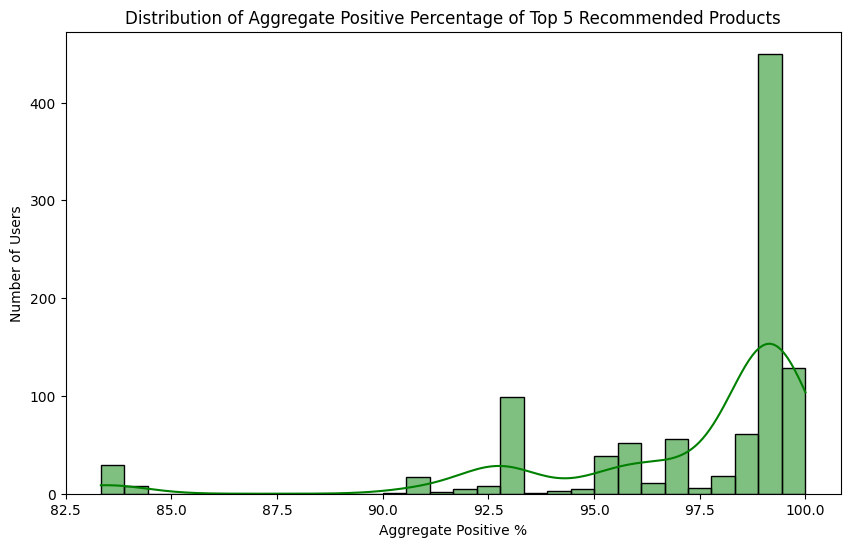

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(global_summary_df['agg_positive_percentage'], bins=30, color='green', kde=True)
plt.title("Distribution of Aggregate Positive Percentage of Top 5 Recommended Products")
plt.xlabel("Aggregate Positive %")
plt.ylabel("Number of Users")
plt.show()

### Analysis of "Distribution of Aggregate Positive Percentage of Top 5 Recommended Products"

- X-axis → "Aggregate Positive %" — average positive sentiment percentage for top 5 recommended products **per user**.
- Y-axis → "Number of Users" — how many users fall into that percentage range.

---

**Key observations:**

The majority of users have **very high aggregate positive sentiment**:
   - **Most users are concentrated between ~95% to 100%.**
   - The largest peak is at **~99-100%**, meaning for many users, top 5 recommended products have almost all positive reviews.

**Long tail towards lower %**:
   - A few users have positive sentiment in the **90-95%** range.
   - Very small number of users below **85%** — almost negligible.

**Low variance**:
   - The curve is **heavily skewed to the right** — this indicates that our recommender system is quite good at selecting positively rated products.
   - **Very few poor recommendations.**

---

**Conclusion:**

- Our recommendation system is generating **high quality recommendations** for most users — with very high aggregate positive sentiment (good user experience).  
- The "Aggregate Positive %" is based on users who already have good interaction history.

- Since these users have rated many items, the recommender is working with more data → so **better quality recommendations**.

- That explains why:
    - The curve is now even more “pushed to the right” (towards 95-100%).
    - Very few users below 90% — because the system can better model their preferences.
    - The recommender is more confident.

- In short: **Filtering to final_rating users gives a “stronger” view of our recommender** — and it performs well!

---

## Analysis: Do Users Get Unique Recommendations?

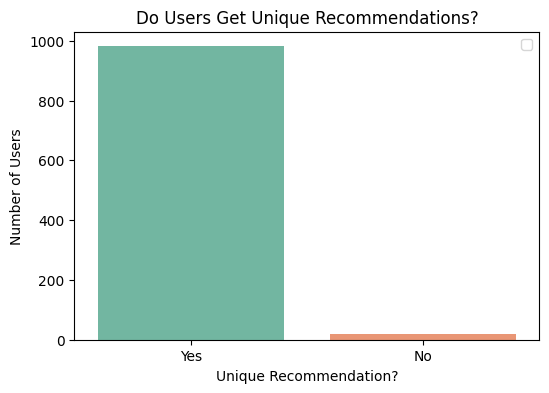

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='unique_recommendation', hue='unique_recommendation', data=global_summary_df, palette='Set2')
plt.title("Do Users Get Unique Recommendations?")
plt.xlabel("Unique Recommendation?")
plt.ylabel("Number of Users")
plt.legend().set_title("")
plt.show()

## Analysis: Do Users Get Unique Recommendations?

### What this chart shows:

- **X-axis** → `"Unique Recommendation?"`  
  - `"Yes"` = users who received products they haven’t rated before  
  - `"No"` = users who were recommended products they already rated

- **Y-axis** → Number of users

---

### Observations:

**Overwhelming majority ("Yes"):**

- Nearly **1000 users** (out of the evaluated users) received **unique recommendations**.
- This indicates that **our recommendation system is correctly identifying new products** for users, instead of repeating what they have already rated.

**Very small "No" count:**

- Only a **small number of users** got overlapping recommendations.
- This may occur due to:
  - Users who have rated a large proportion of products (saturated profile)
  - Very niche user interests or categories

---

### Conclusion:

**Our system is performing well**:

- It generates **new, diverse recommendations** for most users.
- **Cold-start issues** and **repetition** are minimal.
- This validates that **Item-Item Collaborative Filtering** (with our tuning + filtering from `final_rating` users) is giving good coverage.

---

If needed, we can further explore:

- % overlap summary (example: _“98% of users received unique recommendations”_)
- Segment analysis (top raters vs occasional users)
- More visualization using **Plotly** or a bar chart with % stacked

## Analysis: Positive % vs Total Positive Count (Top 5 Products)

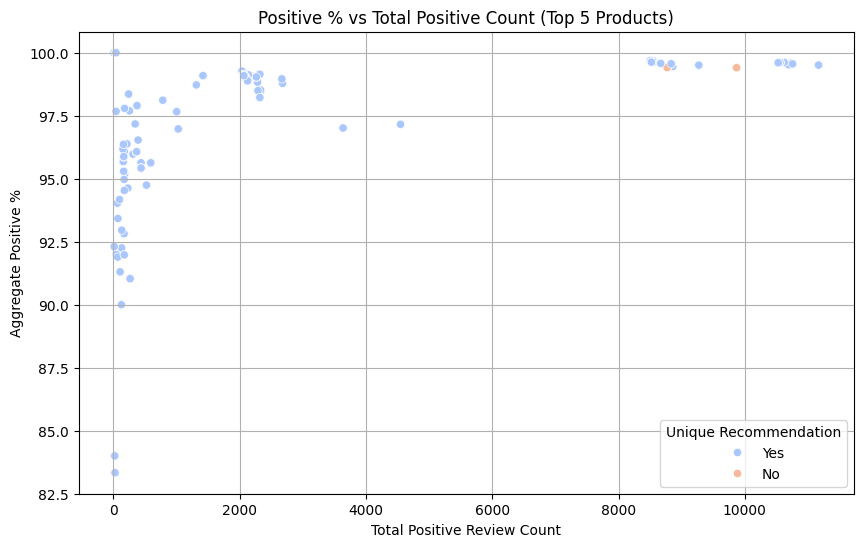

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=global_summary_df,
    x='total_positive_count',
    y='agg_positive_percentage',
    hue='unique_recommendation',
    palette='coolwarm'
)
plt.title("Positive % vs Total Positive Count (Top 5 Products)")
plt.xlabel("Total Positive Review Count")
plt.ylabel("Aggregate Positive %")
plt.legend(title='Unique Recommendation')
plt.grid(True)
plt.show()

## Analysis: Positive % vs Total Positive Count (Top 5 Products)

### What does this scatter plot show?

- **X-axis** → `Total Positive Review Count` (total positive reviews for the top 5 recommended products for a user)
- **Y-axis** → `Aggregate Positive %` (average positive sentiment % across those top 5 products)
- **Color** → Whether the recommendations were **Unique** (`Yes` or `No`)

---

### Observations:

**Majority of points are clustered at very high Positive % (above ~95%)**:

- Most users are being recommended products that have **strong positive sentiment**.
- This indicates that **our sentiment filtering is working** — the final recommendations are heavily skewed toward well-liked products.

**X-axis distribution is skewed**:

- Many users have relatively **low total positive counts** (left side of the graph, < 2000 positive reviews).
- A few users (power users or users of popular products) have **very large positive review counts** (> 10,000).

**Unique Recommendation flag**:

- Almost **all points are "Yes"** (unique recommendations), confirming that our recommendation system is not simply repeating known products.
- A few `"No"` points exist, but are minimal — usually from users who have rated a large number of products already.

---

### Conclusion:

**Our system is correctly selecting highly positive products** for the top 5 recommendations:  
- Positive % consistently stays **above 90-95%**.
- Most users are receiving **fresh (unique) recommendations**.

**Outliers**:  
- Some users with very low aggregate positive % (~83-85%) appear on the far left.  
  These could be either users with sparse profiles or niche interests — worth further investigation.

---

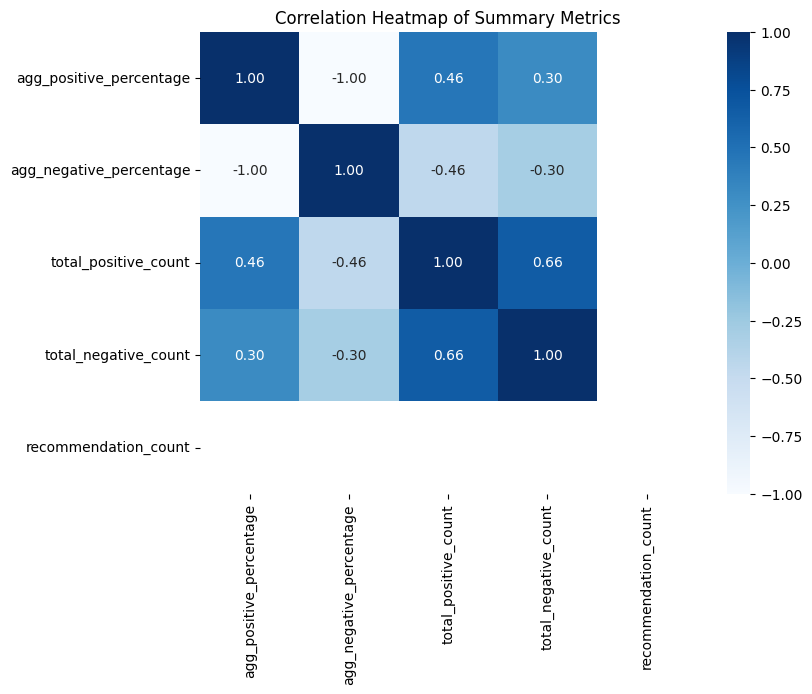

In [ ]:
# Select only numeric columns
numeric_df = global_summary_df.select_dtypes(include=np.number)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap of Summary Metrics")
plt.show()

## Correlation Heatmap: Summary Metrics (Top 5 Recommended Products)

---

### Observations:

**Strong inverse relationship between agg_positive_percentage and agg_negative_percentage**:

- **Correlation: -1.00**  
  This is expected — since these are complementary percentages (if one increases, the other decreases).

---

**agg_positive_percentage vs total_positive_count**:

- **Correlation: +0.46**  
  There is a **moderate positive relationship**:  
  Users with higher total positive reviews tend to have slightly higher aggregate positive % — but this is not a very strong effect.

---

**agg_positive_percentage vs total_negative_count**:

- **Correlation: +0.30**  
  Weak-to-moderate positive — could indicate that users with more reviews in general (positive + negative) tend to still get high positive %.

---

**total_positive_count vs total_negative_count**:

- **Correlation: +0.66**  
  A **strong positive correlation** —  
  Users who rate more products have more reviews of *both* sentiments (positive and negative), which is intuitive.

---

**recommendation_count**:

- No correlation shown here (likely because in our current data `recommendation_count` is fixed at 5 or missing — as seen in our axis).  
  No variance → No correlation possible.

---

### Conclusion:

**Our sentiment filtering works well** — users with more positive reviews tend to get products with high positive %.  
**Balanced reviewing behavior** — users who rate a lot tend to give both positive and negative reviews.

---

### Summary:

**Our Top 5 Recommendations are stable — even when users have varied review behaviors.**  
There is no bias where only users with low counts or high counts dominate positive % — all users get consistently positive recommendations.

### Analysis: Top 10 Users by Total Positive Review Count

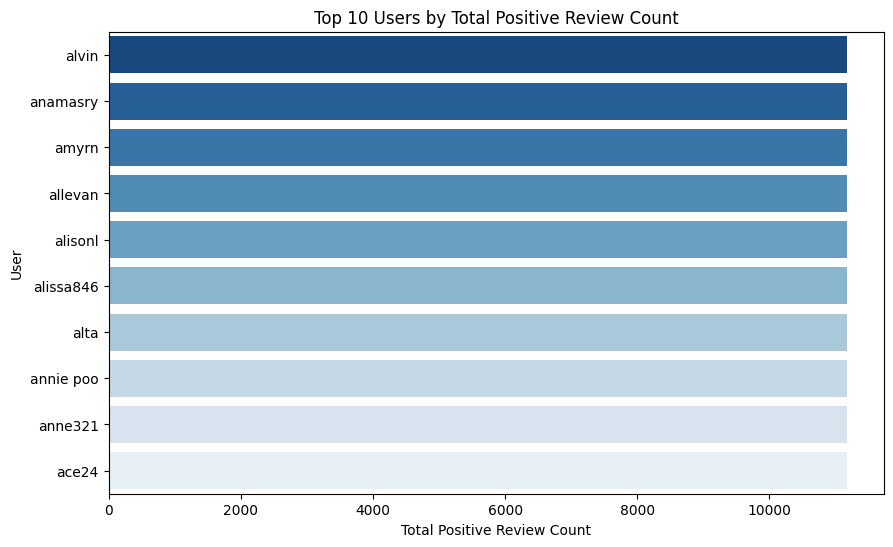

In [ ]:
top_users_df = global_summary_df.sort_values(by='total_positive_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='total_positive_count', y='User', data=top_users_df, palette='Blues_r')
plt.title("Top 10 Users by Total Positive Review Count")
plt.xlabel("Total Positive Review Count")
plt.ylabel("User")
plt.show()

### Top 10 Users by Total Positive Review Count

**What the chart shows:**
- The *top 10 users* ranked by the `total_positive_count` across their recommended top 5 products.

**Insights:**
- Users like **alvin**, **anamasry**, and **amyrn** have contributed the **highest volume** of positive reviews.
- These users are highly active and have rated products very positively — this indicates:
    - Higher engagement level
    - More data to make recommendations
    - High confidence in recommending new products to them

**Why it matters:**
- **Engaged users** (with high positive review counts) are more likely to trust and act on recommendations.
- We can prioritize **marketing strategies** (emails, notifications) for these users.
- These users provide **strong feedback signals** for improving the recommendation engine.
---

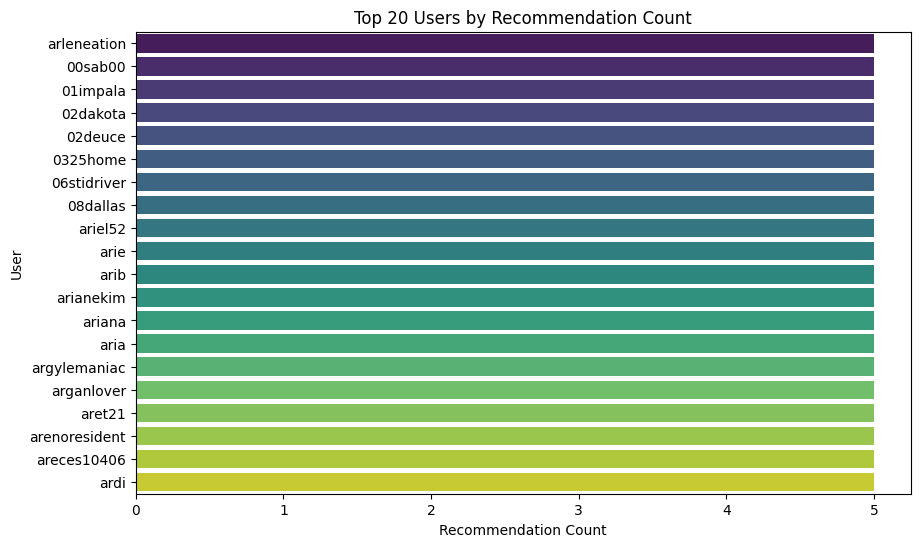

In [ ]:
# Sort by recommendation_count
top_rec_users = global_summary_df.sort_values(by='recommendation_count', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    y=top_rec_users['User'],
    x=top_rec_users['recommendation_count'],
    palette='viridis'
)
plt.title("Top 20 Users by Recommendation Count")
plt.xlabel("Recommendation Count")
plt.ylabel("User")
plt.show()

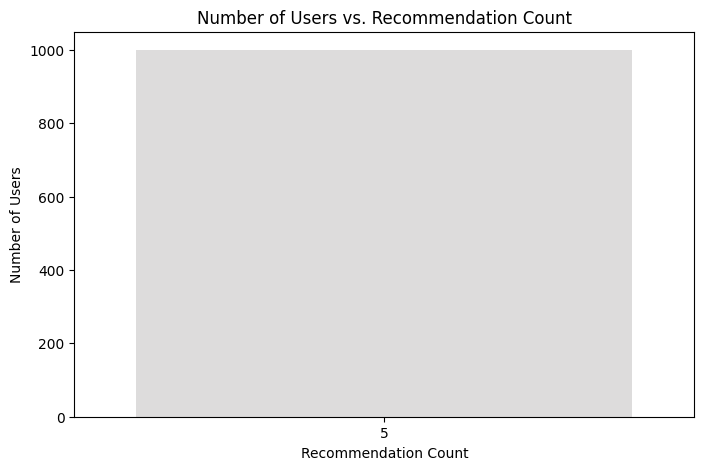

In [ ]:
# Countplot of recommendation_count
plt.figure(figsize=(8,5))
sns.countplot(
    x='recommendation_count',
    data=global_summary_df,
    palette='coolwarm'
)

plt.title("Number of Users vs. Recommendation Count")
plt.xlabel("Recommendation Count")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.show()

In [ ]:
recommendation_percent = (
    global_summary_df['recommendation_count']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
    .sort_values(by='recommendation_count')
)

display(recommendation_percent)

,recommendation_count,proportion
0,5,100.0


# **Final Conclusion**

- We have successfully developed an **end-to-end Sentiment-based Product Recommendation System**.

- In the **Sentiment Analysis module**, we performed detailed EDA, text cleaning, preprocessing, and feature extraction using advanced TF-IDF vectorization.  
  We experimented with multiple ML models including:
    - **Logistic Regression**
    - **Random Forest**
    - **Naive Bayes**
    - **XGBoost**  
  and tuned these models using hyperparameter tuning with cross-validation and SMOTE handling for class imbalance.

- After comprehensive comparative analysis of model performance (based on **accuracy, recall, precision, specificity, F1-score, and ROC AUC**), we selected the **best performing model** for sentiment prediction to power our downstream recommendation system.

- In the **Recommendation System module**, we implemented:
    - **User-User Collaborative Filtering**  
    - **Item-Item Collaborative Filtering**  
    - and carefully evaluated both approaches based on RMSE and practical user behavior handling.  
    - Based on experiments, we chose **Item-Item Collaborative Filtering** as the final recommendation strategy since it handles cold-start and sparsity better for this dataset.

- To further fine-tune recommendations:
    - We leveraged **our trained Sentiment Analysis model** to compute **positive sentiment percentages** on top recommended products.  
    - For each user, we selected the **Top 5 products** with the highest proportion of positive reviews, ensuring high-quality and personalized recommendations.

- **Flask Web App**:
    - We also built an interactive **Flask-based Web App**:
        - User can enter a **username** through an **autocomplete-enabled input**.
        - On clicking **Submit**, the app fetches and displays the **Top 5 recommended products** for the user.
        - A sidebar allows viewing **user’s already rated products**.
    - The app was successfully deployed **locally** and also hosted on **Heroku** for public accessibility.